In [1]:
## From Kai's code

In [2]:
# pip install ase dscribe matplotlib seaborn scikit-learn tensorflow
# pip install --upgrade pip
# pip install tensorflow

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dscribe.descriptors import SOAP
from ase.io import read, write
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.decomposition import KernelPCA
from matplotlib.colors import Normalize
from tensorflow.keras.regularizers import L1, L2

In [2]:
path_to_POSCAR_MBT_labeled = 'DFT_CONTCARs_MBT/'
path_to_POSCAR_MBT_unlabeled = 'random_500_unlabelled_POSCARs/'

In [3]:
## Read POSCARs file and extract the information
def read_POSCAR(file_path):

    poscar_info_list = []
    atomic_species_list = []
    unique_atomic_species_list = set()
    
    for file in os.listdir(file_path):
        if file.endswith('.vasp'):
            poscar_path = os.path.join(file_path, file)
            poscar = read(poscar_path, format='vasp')
            poscar_info_list.append(poscar)
            atomic_species_list.append(poscar.get_chemical_symbols())
            for atoms in atomic_species_list:
                unique_atomic_species_list.update(poscar.get_chemical_symbols())
    return poscar_info_list, atomic_species_list, list(unique_atomic_species_list)

poscar_info_list_labeled, atomic_species_list_labeled, unique_atomic_species_list_labeled = read_POSCAR(path_to_POSCAR_MBT_labeled)
poscar_info_list_unlabeled, atomic_species_list_unlabeled, unique_atomic_species_list_unlabeled = read_POSCAR(path_to_POSCAR_MBT_unlabeled)

In [4]:
## Extract the SOAP descriptors
def get_SOAP_descriptor(poscar_info_list, unique_atomic_species_list, r_cut, n_max, l_max):
    
    soap = SOAP(species = unique_atomic_species_list,
                r_cut = r_cut,
                n_max = n_max,
                l_max = l_max,
                sigma = 0.5,    # default: 1.0
                rbf = 'gto',    # deafult: 'gto'
                average = 'inner',  # default: 'off'
                periodic = True,  # default: False
                sparse = False)    # default: False
    soap_desc = []
    for struct in poscar_info_list:
        soap_struct = soap.create(struct)
        soap_desc.append(soap_struct)
    return np.vstack(soap_desc)

## call the SOAP function
soap_desc_labeled = get_SOAP_descriptor(poscar_info_list_labeled,unique_atomic_species_list_labeled, 9.0, 6, 5)
soap_desc_unlabeled = get_SOAP_descriptor(poscar_info_list_unlabeled, unique_atomic_species_list_unlabeled, 9.0, 6, 5)
soap_desc_combined = np.vstack((soap_desc_labeled, soap_desc_unlabeled))

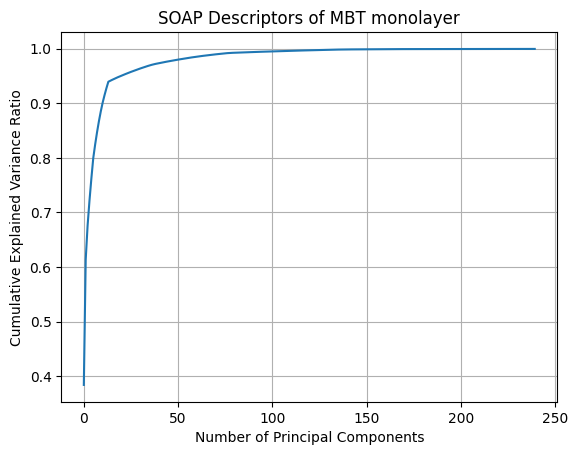

In [5]:
## Plot the PCA variance to determine the number of principal components
def plot_PCA_variance(soap_desc, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(soap_desc)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('SOAP Descriptors of MBT monolayer')
    plt.grid(True)
    plt.show()
    
plot_PCA_variance(soap_desc_combined,240) # max we can go to 740

In [6]:
def perform_pca(soap_desc, optimal_components):
    pca = PCA(n_components = optimal_components)
    soap_pca = pca.fit_transform(soap_desc)
    return soap_pca

optimized_pca_combined = perform_pca(soap_desc_combined, 100)
scaler = StandardScaler()
X = scaler.fit_transform(optimized_pca_combined)
latent_size = 64
input_dim = X.shape[1]

In [131]:
# Load labelled data
monolayer_MBT_DFT_data = pd.read_csv('id_props_240_labelled_data_MBT.csv')
monolayer_MBT_DFT_data['Eg_class'] = [1 if i > 0 else 0 for i in monolayer_MBT_DFT_data['Eg']]
y = monolayer_MBT_DFT_data[['Ef_per_cell', 'Mu_per_cell', 'Eg']]

# Create a mask for the labelled data
mask = np.zeros(X.shape[0])
mask[:len(y)] = 1  # First len(y) entries are labelled

# Create a combined target array with zeros for unlabelled data
y_combined = np.vstack((y.values, np.zeros((soap_desc_unlabeled.shape[0], y.shape[1]))))

# Split the combined dataset
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(X, y_combined, mask, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(X_train, y_train, mask_train, test_size=0.25, random_state=1)

In [290]:
# encoder
encoder_input = keras.Input(shape = (input_dim,))
encoder = Dropout(0.05)(encoder_input)
encoder_output = Dense(latent_size, activation = 'selu')(encoder)

# decoder
#decoder_output = Dense(input_dim, activation = 'linear')(encoder_output)

decoder = Dropout(0.05)(encoder_output)
decoder_output = Dense(input_dim, activation = 'linear')(decoder)

# autoencoder
autoencoder = Model(inputs = encoder_input, outputs = decoder_output)
autoencoder.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError())

# FFNN
ffnn_MBT_input = Dense(32, activation = 'selu')(encoder_output)
ffnn_MBT = Dropout(0.2)(ffnn_MBT_input)
#ffnn_MBT = Dense(16, activation = 'selu')(ffnn_MBT_input)
#ffnn_MBT = Dropout(0.2)(ffnn_MBT_input)
#ffnn_MBT = Dense(16, activation = 'selu')(ffnn_MBT)
#ffnn_MBT = Dropout(0.1)(ffnn_MBT)
#ffnn_MBT = Dense(4, activation = 'selu')(ffnn_MBT)
ffnn_MBT_output = Dense(3, activation = 'linear')(ffnn_MBT)

# Combined Model
combined_output = [decoder_output, ffnn_MBT_output]
combined_model = Model(inputs = encoder_input, outputs = combined_output)
combined_model.compile(optimizer = Adam(learning_rate = 0.001), loss = [MeanSquaredError(), MeanAbsoluteError],
                       loss_weights = [1, 10], metrics = [MeanSquaredError, MeanAbsoluteError]) 

# Training
history = combined_model.fit(X_train, [X_train, y_train],
                             validation_data = (X_val, [X_val, y_val]), epochs = 500, batch_size = 32,
                             sample_weight = [mask_train, mask_train])

# # Training
# history = combined_model.fit(X_train, [X_train, y_train],
#                              validation_data = (X_val, [X_val, y_val]), epochs = 500, batch_size = 32,
#                              callbacks = [EarlyStopping(patience = 50, min_delta = 0.001)], sample_weight = [mask_train, mask_train])

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - dense_178_mean_squared_error: 2.0359 - dense_180_mean_absolute_error: 1.4717 - loss: 8.5469 - val_dense_178_mean_squared_error: 1.7974 - val_dense_180_mean_absolute_error: 1.0944 - val_loss: 12.6602
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 1.8770 - dense_180_mean_absolute_error: 1.2166 - loss: 6.7035 - val_dense_178_mean_squared_error: 1.7054 - val_dense_180_mean_absolute_error: 0.9905 - val_loss: 11.5092
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 1.7532 - dense_180_mean_absolute_error: 1.0817 - loss: 5.7070 - val_dense_178_mean_squared_error: 1.6206 - val_dense_180_mean_absolute_error: 0.9218 - val_loss: 10.7385
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 1.6445 - dense_180_mean_absolute_error: 0.9734 - loss: 4.3670 - val_dense_178_mean_squared_error: 1.5456 - val_dense_180_mean_absolute_error: 0.8870 - val_loss:

Epoch 30/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.7893 - dense_180_mean_absolute_error: 0.6600 - loss: 1.8338 - val_dense_178_mean_squared_error: 0.8819 - val_dense_180_mean_absolute_error: 0.6016 - val_loss: 6.8692
Epoch 31/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.7903 - dense_180_mean_absolute_error: 0.6687 - loss: 1.9962 - val_dense_178_mean_squared_error: 0.8757 - val_dense_180_mean_absolute_error: 0.6003 - val_loss: 6.8611
Epoch 32/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.7777 - dense_180_mean_absolute_error: 0.6668 - loss: 1.9590 - val_dense_178_mean_squared_error: 0.8686 - val_dense_180_mean_absolute_error: 0.5921 - val_loss: 6.7767
Epoch 33/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.8019 - dense_180_mean_absolute_error: 0.6526 - loss: 2.1006 - val_dense_178_mean_squared_error: 0.8620 - val_dense_180_mean_absolute_error: 0.5906 - val_loss:

Epoch 59/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6889 - dense_180_mean_absolute_error: 0.5947 - loss: 1.3672 - val_dense_178_mean_squared_error: 0.7861 - val_dense_180_mean_absolute_error: 0.5600 - val_loss: 6.4035
Epoch 60/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6953 - dense_180_mean_absolute_error: 0.5890 - loss: 1.3108 - val_dense_178_mean_squared_error: 0.7847 - val_dense_180_mean_absolute_error: 0.5628 - val_loss: 6.4229
Epoch 61/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6930 - dense_180_mean_absolute_error: 0.5750 - loss: 1.3195 - val_dense_178_mean_squared_error: 0.7834 - val_dense_180_mean_absolute_error: 0.5663 - val_loss: 6.4547
Epoch 62/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6913 - dense_180_mean_absolute_error: 0.5974 - loss: 1.3760 - val_dense_178_mean_squared_error: 0.7821 - val_dense_180_mean_absolute_error: 0.5681 - val_loss:

Epoch 88/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6723 - dense_180_mean_absolute_error: 0.6164 - loss: 1.0407 - val_dense_178_mean_squared_error: 0.7653 - val_dense_180_mean_absolute_error: 0.6118 - val_loss: 6.9195
Epoch 89/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6748 - dense_180_mean_absolute_error: 0.6042 - loss: 1.1842 - val_dense_178_mean_squared_error: 0.7651 - val_dense_180_mean_absolute_error: 0.6122 - val_loss: 6.9329
Epoch 90/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6770 - dense_180_mean_absolute_error: 0.5926 - loss: 1.2636 - val_dense_178_mean_squared_error: 0.7646 - val_dense_180_mean_absolute_error: 0.6152 - val_loss: 6.9580
Epoch 91/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6704 - dense_180_mean_absolute_error: 0.6071 - loss: 1.0938 - val_dense_178_mean_squared_error: 0.7633 - val_dense_180_mean_absolute_error: 0.6140 - val_loss:

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6774 - dense_180_mean_absolute_error: 0.6505 - loss: 0.9389 - val_dense_178_mean_squared_error: 0.7558 - val_dense_180_mean_absolute_error: 0.6628 - val_loss: 7.4333
Epoch 117/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6695 - dense_180_mean_absolute_error: 0.6250 - loss: 0.9870 - val_dense_178_mean_squared_error: 0.7555 - val_dense_180_mean_absolute_error: 0.6583 - val_loss: 7.3810
Epoch 118/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6713 - dense_180_mean_absolute_error: 0.6477 - loss: 0.9609 - val_dense_178_mean_squared_error: 0.7548 - val_dense_180_mean_absolute_error: 0.6559 - val_loss: 7.3521
Epoch 119/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6686 - dense_180_mean_absolute_error: 0.6515 - loss: 1.0392 - val_dense_178_mean_squared_error: 0.7546 - val_dense_180_mean_absolute_error: 0.6651 - val_loss: 7.4493
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6664 - dense_180_mean_absolute_error: 0.6915 - loss: 0.9091 - val_dense_178_mean_squared_error: 0.7452 - val_dense_180_mean_absolute_error: 0.7097 - val_loss: 7.8878
Epoch 145/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6698 - dense_180_mean_absolute_error: 0.7045 - loss: 0.9286 - val_dense_178_mean_squared_error: 0.7447 - val_dense_180_mean_absolute_error: 0.7037 - val_loss: 7.8306
Epoch 146/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6542 - dense_180_mean_absolute_error: 0.6577 - loss: 1.0208 - val_dense_178_mean_squared_error: 0.7437 - val_dense_180_mean_absolute_error: 0.7164 - val_loss: 7.9555
Epoch 147/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6718 - dense_180_mean_absolute_error: 0.7315 - loss: 0.9405 - val_dense_178_mean_squared_error: 0.7434 - val_dense_180_mean_absolute_error: 0.7188 - val_loss: 7.9699
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6497 - dense_180_mean_absolute_error: 0.6980 - loss: 0.9107 - val_dense_178_mean_squared_error: 0.7381 - val_dense_180_mean_absolute_error: 0.7494 - val_loss: 8.2760
Epoch 173/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6564 - dense_180_mean_absolute_error: 0.7318 - loss: 0.9285 - val_dense_178_mean_squared_error: 0.7371 - val_dense_180_mean_absolute_error: 0.7534 - val_loss: 8.3232
Epoch 174/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6607 - dense_180_mean_absolute_error: 0.7378 - loss: 0.9366 - val_dense_178_mean_squared_error: 0.7371 - val_dense_180_mean_absolute_error: 0.7463 - val_loss: 8.2481
Epoch 175/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - dense_178_mean_squared_error: 0.6583 - dense_180_mean_absolute_error: 0.7246 - loss: 0.8114 - val_dense_178_mean_squared_error: 0.7366 - val_dense_180_mean_absolute_error: 0.7429 - val_loss: 8.2133
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6592 - dense_180_mean_absolute_error: 0.7594 - loss: 0.8746 - val_dense_178_mean_squared_error: 0.7338 - val_dense_180_mean_absolute_error: 0.7815 - val_loss: 8.6079
Epoch 201/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6454 - dense_180_mean_absolute_error: 0.7950 - loss: 0.9737 - val_dense_178_mean_squared_error: 0.7329 - val_dense_180_mean_absolute_error: 0.7686 - val_loss: 8.4705
Epoch 202/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6433 - dense_180_mean_absolute_error: 0.7567 - loss: 0.7985 - val_dense_178_mean_squared_error: 0.7323 - val_dense_180_mean_absolute_error: 0.7686 - val_loss: 8.4577
Epoch 203/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6608 - dense_180_mean_absolute_error: 0.7662 - loss: 0.8950 - val_dense_178_mean_squared_error: 0.7314 - val_dense_180_mean_absolute_error: 0.7934 - val_loss: 8.7110
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6351 - dense_180_mean_absolute_error: 0.7695 - loss: 0.9866 - val_dense_178_mean_squared_error: 0.7245 - val_dense_180_mean_absolute_error: 0.8108 - val_loss: 8.8749
Epoch 229/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6360 - dense_180_mean_absolute_error: 0.7769 - loss: 0.8254 - val_dense_178_mean_squared_error: 0.7250 - val_dense_180_mean_absolute_error: 0.8090 - val_loss: 8.8585
Epoch 230/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6440 - dense_180_mean_absolute_error: 0.7760 - loss: 0.8565 - val_dense_178_mean_squared_error: 0.7250 - val_dense_180_mean_absolute_error: 0.8175 - val_loss: 8.9419
Epoch 231/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6603 - dense_180_mean_absolute_error: 0.8206 - loss: 0.8845 - val_dense_178_mean_squared_error: 0.7245 - val_dense_180_mean_absolute_error: 0.8117 - val_loss: 8.8926
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6316 - dense_180_mean_absolute_error: 0.8295 - loss: 0.8010 - val_dense_178_mean_squared_error: 0.7187 - val_dense_180_mean_absolute_error: 0.8392 - val_loss: 9.1372
Epoch 257/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - dense_178_mean_squared_error: 0.6430 - dense_180_mean_absolute_error: 0.8400 - loss: 0.7680 - val_dense_178_mean_squared_error: 0.7191 - val_dense_180_mean_absolute_error: 0.8338 - val_loss: 9.0856
Epoch 258/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6362 - dense_180_mean_absolute_error: 0.8420 - loss: 0.8475 - val_dense_178_mean_squared_error: 0.7181 - val_dense_180_mean_absolute_error: 0.8394 - val_loss: 9.1561
Epoch 259/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6531 - dense_180_mean_absolute_error: 0.8599 - loss: 0.8157 - val_dense_178_mean_squared_error: 0.7177 - val_dense_180_mean_absolute_error: 0.8523 - val_loss: 9.2823
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6330 - dense_180_mean_absolute_error: 0.8477 - loss: 0.7612 - val_dense_178_mean_squared_error: 0.7108 - val_dense_180_mean_absolute_error: 0.8586 - val_loss: 9.3338
Epoch 285/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6320 - dense_180_mean_absolute_error: 0.8240 - loss: 0.7586 - val_dense_178_mean_squared_error: 0.7100 - val_dense_180_mean_absolute_error: 0.8586 - val_loss: 9.3310
Epoch 286/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6381 - dense_180_mean_absolute_error: 0.8465 - loss: 0.7680 - val_dense_178_mean_squared_error: 0.7099 - val_dense_180_mean_absolute_error: 0.8611 - val_loss: 9.3523
Epoch 287/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6467 - dense_180_mean_absolute_error: 0.8388 - loss: 0.7721 - val_dense_178_mean_squared_error: 0.7098 - val_dense_180_mean_absolute_error: 0.8684 - val_loss: 9.4412
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6348 - dense_180_mean_absolute_error: 0.8849 - loss: 0.7152 - val_dense_178_mean_squared_error: 0.7037 - val_dense_180_mean_absolute_error: 0.8824 - val_loss: 9.5725
Epoch 313/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6355 - dense_180_mean_absolute_error: 0.9130 - loss: 0.6923 - val_dense_178_mean_squared_error: 0.7035 - val_dense_180_mean_absolute_error: 0.8871 - val_loss: 9.6205
Epoch 314/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6177 - dense_180_mean_absolute_error: 0.8718 - loss: 0.6723 - val_dense_178_mean_squared_error: 0.7032 - val_dense_180_mean_absolute_error: 0.8856 - val_loss: 9.6057
Epoch 315/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6256 - dense_180_mean_absolute_error: 0.9019 - loss: 0.7683 - val_dense_178_mean_squared_error: 0.7032 - val_dense_180_mean_absolute_error: 0.8931 - val_loss: 9.6717
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6119 - dense_180_mean_absolute_error: 0.8935 - loss: 0.8062 - val_dense_178_mean_squared_error: 0.6958 - val_dense_180_mean_absolute_error: 0.9068 - val_loss: 9.8155
Epoch 341/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6201 - dense_180_mean_absolute_error: 0.8422 - loss: 0.7401 - val_dense_178_mean_squared_error: 0.6962 - val_dense_180_mean_absolute_error: 0.8981 - val_loss: 9.7156
Epoch 342/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6096 - dense_180_mean_absolute_error: 0.9024 - loss: 0.6955 - val_dense_178_mean_squared_error: 0.6957 - val_dense_180_mean_absolute_error: 0.9237 - val_loss: 9.9679
Epoch 343/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6166 - dense_180_mean_absolute_error: 0.9193 - loss: 0.6105 - val_dense_178_mean_squared_error: 0.6951 - val_dense_180_mean_absolute_error: 0.8999 - val_loss: 9.7340
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6042 - dense_180_mean_absolute_error: 0.9294 - loss: 0.6869 - val_dense_178_mean_squared_error: 0.6896 - val_dense_180_mean_absolute_error: 0.9152 - val_loss: 9.8677
Epoch 369/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6175 - dense_180_mean_absolute_error: 0.8976 - loss: 0.7196 - val_dense_178_mean_squared_error: 0.6899 - val_dense_180_mean_absolute_error: 0.9273 - val_loss: 10.0020
Epoch 370/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6051 - dense_180_mean_absolute_error: 0.9015 - loss: 0.7431 - val_dense_178_mean_squared_error: 0.6889 - val_dense_180_mean_absolute_error: 0.9297 - val_loss: 10.0255
Epoch 371/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6158 - dense_180_mean_absolute_error: 0.8985 - loss: 0.6440 - val_dense_178_mean_squared_error: 0.6883 - val_dense_180_mean_absolute_error: 0.9178 - val_loss: 9.9124


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6059 - dense_180_mean_absolute_error: 0.9246 - loss: 0.6197 - val_dense_178_mean_squared_error: 0.6822 - val_dense_180_mean_absolute_error: 0.8984 - val_loss: 9.6979
Epoch 397/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5884 - dense_180_mean_absolute_error: 0.8565 - loss: 0.7033 - val_dense_178_mean_squared_error: 0.6825 - val_dense_180_mean_absolute_error: 0.9201 - val_loss: 9.9320
Epoch 398/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6051 - dense_180_mean_absolute_error: 0.9304 - loss: 0.6494 - val_dense_178_mean_squared_error: 0.6821 - val_dense_180_mean_absolute_error: 0.9278 - val_loss: 9.9958
Epoch 399/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5850 - dense_180_mean_absolute_error: 0.8770 - loss: 0.6471 - val_dense_178_mean_squared_error: 0.6811 - val_dense_180_mean_absolute_error: 0.9212 - val_loss: 9.9290
Ep

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6008 - dense_180_mean_absolute_error: 0.9068 - loss: 0.6229 - val_dense_178_mean_squared_error: 0.6736 - val_dense_180_mean_absolute_error: 0.9282 - val_loss: 9.9854
Epoch 425/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5937 - dense_180_mean_absolute_error: 0.9477 - loss: 0.6707 - val_dense_178_mean_squared_error: 0.6735 - val_dense_180_mean_absolute_error: 0.9476 - val_loss: 10.1739
Epoch 426/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.6122 - dense_180_mean_absolute_error: 0.9421 - loss: 0.6170 - val_dense_178_mean_squared_error: 0.6735 - val_dense_180_mean_absolute_error: 0.9361 - val_loss: 10.0590
Epoch 427/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5960 - dense_180_mean_absolute_error: 0.9293 - loss: 0.6029 - val_dense_178_mean_squared_error: 0.6733 - val_dense_180_mean_absolute_error: 0.9305 - val_loss: 10.0070

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5751 - dense_180_mean_absolute_error: 0.9039 - loss: 0.7615 - val_dense_178_mean_squared_error: 0.6690 - val_dense_180_mean_absolute_error: 0.9474 - val_loss: 10.1700
Epoch 453/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5866 - dense_180_mean_absolute_error: 0.9285 - loss: 0.6393 - val_dense_178_mean_squared_error: 0.6686 - val_dense_180_mean_absolute_error: 0.9462 - val_loss: 10.1608
Epoch 454/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5574 - dense_180_mean_absolute_error: 0.8862 - loss: 0.7761 - val_dense_178_mean_squared_error: 0.6685 - val_dense_180_mean_absolute_error: 0.9316 - val_loss: 10.0020
Epoch 455/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5874 - dense_180_mean_absolute_error: 0.9274 - loss: 0.6115 - val_dense_178_mean_squared_error: 0.6690 - val_dense_180_mean_absolute_error: 0.9456 - val_loss: 10.158

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5821 - dense_180_mean_absolute_error: 0.9307 - loss: 0.5761 - val_dense_178_mean_squared_error: 0.6630 - val_dense_180_mean_absolute_error: 0.9394 - val_loss: 10.0997
Epoch 481/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5779 - dense_180_mean_absolute_error: 0.9458 - loss: 0.6520 - val_dense_178_mean_squared_error: 0.6629 - val_dense_180_mean_absolute_error: 0.9479 - val_loss: 10.1912
Epoch 482/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5745 - dense_180_mean_absolute_error: 0.9456 - loss: 0.6353 - val_dense_178_mean_squared_error: 0.6625 - val_dense_180_mean_absolute_error: 0.9519 - val_loss: 10.2180
Epoch 483/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_178_mean_squared_error: 0.5561 - dense_180_mean_absolute_error: 0.8945 - loss: 0.7240 - val_dense_178_mean_squared_error: 0.6611 - val_dense_180_mean_absolute_error: 0.9495 - val_loss: 10.200

In [291]:
history.history.keys()

dict_keys(['dense_178_mean_squared_error', 'dense_180_mean_absolute_error', 'loss', 'val_dense_178_mean_squared_error', 'val_dense_180_mean_absolute_error', 'val_loss'])

In [292]:
combined_model.summary()

Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)   │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_115 (Dropout)         │ (None, 100)               │               0 │ input_layer_42[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_177 (Dense)             │ (None, 64)                │           6,464 │ dropout_115[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_179 (Dense)             │ (None, 32)                │           2,080 │ dense_177[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_116 (Dropout)         │ (None, 64)                │               0 │ dense_177[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_117 (Dropout)         │ (None, 32)                │               0 │ dense_179[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_178 (Dense)             │ (None, 100)               │           6,500 │ dropout_116[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_180 (Dense)             │ (None, 3)                 │              99 │ dropout_117[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 45,431 (177.47 KB)

 Trainable params: 15,143 (59.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,288 (118.32 KB)

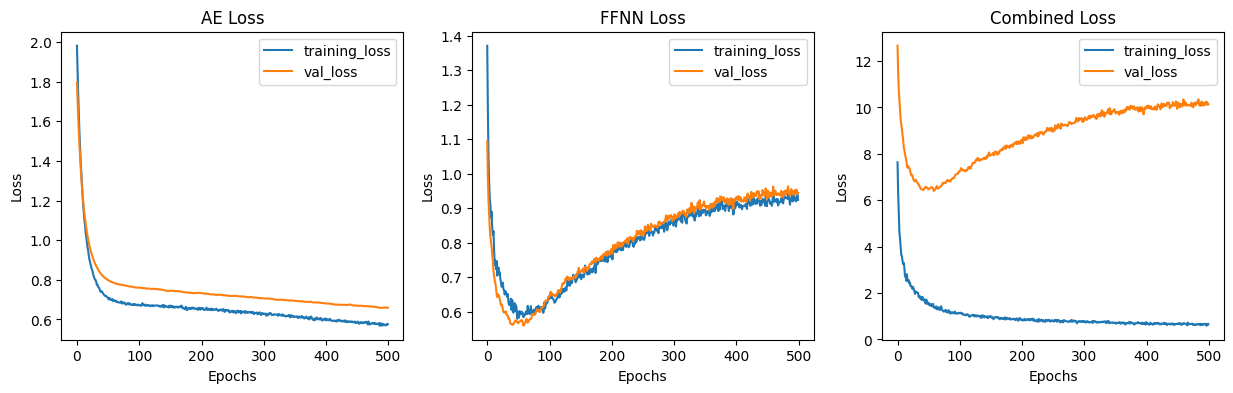

In [293]:
fig,ax = plt.subplots(1,3, figsize = (15,4))
title = ['AE Loss', 'FFNN Loss', 'Combined Loss']
keys = list(history.history.keys())
key_pairs = [(keys[i], keys[i+3]) for i in range(3)]

for i in range(3):
    ax[i].plot(history.history[key_pairs[i][0]], label='training_loss')
    ax[i].plot(history.history[key_pairs[i][1]], label='val_loss')

    ax[i].set_title(title[i])
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


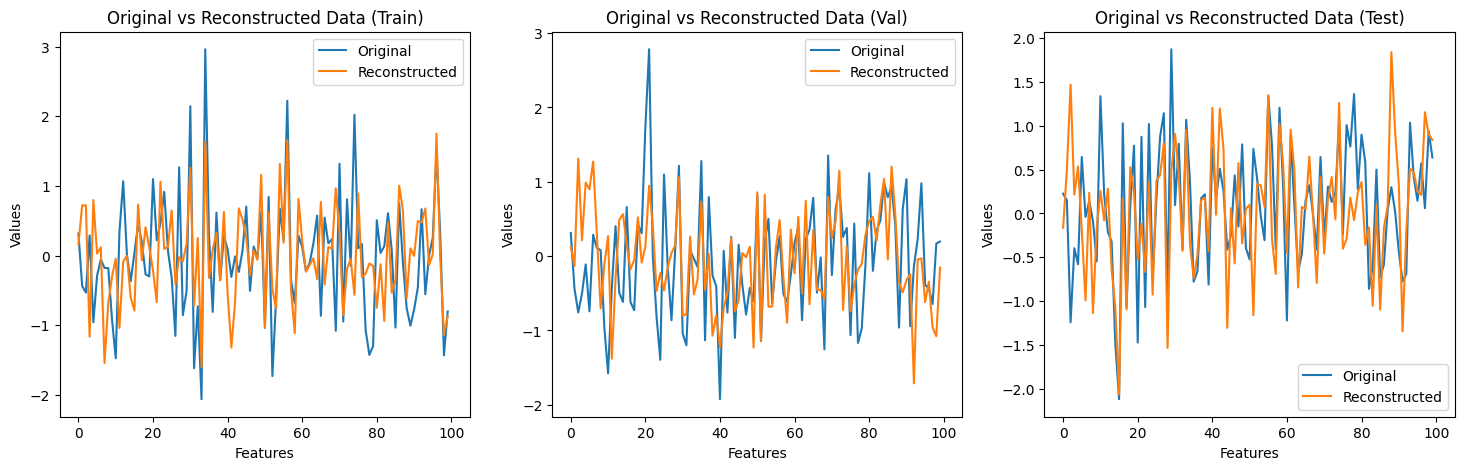

In [294]:
reconstructed_X_train = autoencoder.predict(X_train)
reconstructed_X_val = autoencoder.predict(X_val)
reconstructed_X_test = autoencoder.predict(X_test)

sample_idx_train = X_train[0]
sample_idx_val = X_val[0]
sample_idx_test = X_test[0]

fig, ax = plt.subplots(1,3, figsize = (18,5))

ax[0].plot(X_train[0], label = 'Original')
ax[1].plot(X_val[0], label = 'Original')
ax[2].plot(X_test[0], label = 'Original')

ax[0].plot(reconstructed_X_train[0], label = 'Reconstructed')
ax[1].plot(reconstructed_X_val[0], label = 'Reconstructed')
ax[2].plot(reconstructed_X_test[0], label = 'Reconstructed')

ax[0].set_xlabel('Features')
ax[0].set_ylabel('Values')

ax[1].set_xlabel('Features')
ax[1].set_ylabel('Values')

ax[2].set_xlabel('Features')
ax[2].set_ylabel('Values')

ax[0].set_title('Original vs Reconstructed Data (Train)')
ax[1].set_title('Original vs Reconstructed Data (Val)')
ax[2].set_title('Original vs Reconstructed Data (Test)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlim([-5, X.shape[1]+5])
ax[1].set_xlim([-5, X.shape[1]+5])
ax[2].set_xlim([-5, X.shape[1]+5])

plt.show()

In [295]:
pred_train = combined_model.predict(X_train)#, [X_train, y_train])
pred_val = combined_model.predict(X_val)#, [X_val, y_val])
pred_test = combined_model.predict(X_test)#, [X_test, y_test])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


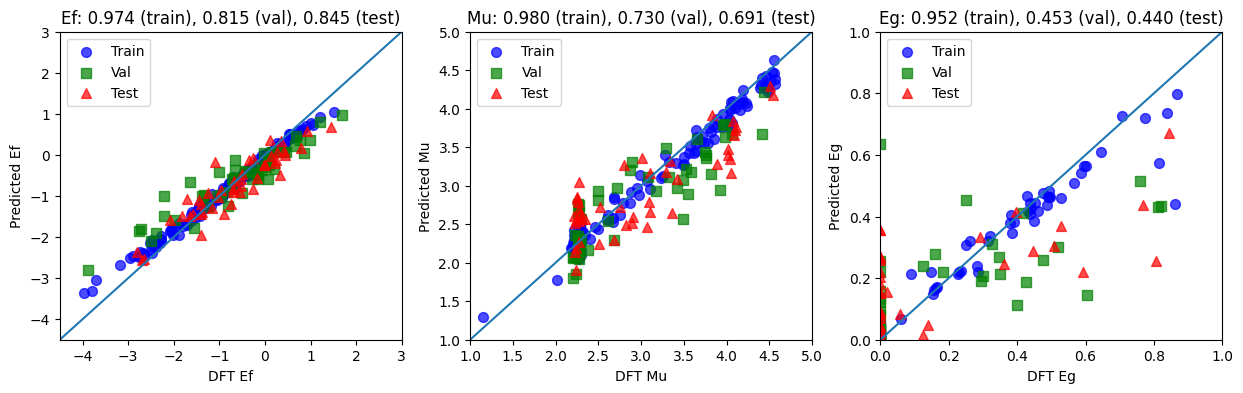

In [296]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (15,4))
ax1.scatter(y_train[mask_train==1][:, 0], pred_train[1][mask_train==1][:,0], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax1.scatter(y_val[mask_val==1][:, 0], pred_val[1][mask_val==1][:,0], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax1.scatter(y_test[mask_test==1][:, 0], pred_test[1][mask_test==1][:,0], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train[mask_train==1][:, 1], pred_train[1][mask_train==1][:,1], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax2.scatter(y_val[mask_val==1][:, 1], pred_val[1][mask_val==1][:,1], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax2.scatter(y_test[mask_test==1][:, 1], pred_test[1][mask_test==1][:,1], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax2.plot([0, 5], [0, 5])

ax3.scatter(y_train[mask_train==1][:, 2], pred_train[1][mask_train==1][:,2], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax3.scatter(y_val[mask_val==1][:, 2], pred_val[1][mask_val==1][:,2], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax3.scatter(y_test[mask_test==1][:, 2], pred_test[1][mask_test==1][:,2], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax3.plot([0, 1], [0, 1])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train[mask_train==1][:, 0], pred_train[1][mask_train==1][:,0]),metrics.r2_score(y_val[mask_val==1][:, 0], pred_val[1][mask_val==1][:,0]),metrics.r2_score(y_test[mask_test==1][:, 0], pred_test[1][mask_test==1][:,0])))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train[mask_train==1][:, 1], pred_train[1][mask_train==1][:,1]),metrics.r2_score(y_val[mask_val==1][:, 1], pred_val[1][mask_val==1][:,1]),metrics.r2_score(y_test[mask_test==1][:, 1], pred_test[1][mask_test==1][:,1])))
ax3.set_title('Eg: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train[mask_train==1][:, 2], pred_train[1][mask_train==1][:,2]),metrics.r2_score(y_val[mask_val==1][:, 2], pred_val[1][mask_val==1][:,2]),metrics.r2_score(y_test[mask_test==1][:, 2], pred_test[1][mask_test==1][:,2])))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax3.set_xlabel('DFT Eg')
ax3.set_ylabel('Predicted Eg')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

In [297]:
# Separate the labelled data from the predictions
mask_train_labelled = mask_train == 1
mask_val_labelled = mask_val == 1
mask_test_labelled = mask_test == 1

# Compute evaluation metrics for the labelled training data
r2_train_ef = metrics.r2_score(y_train[mask_train_labelled][:, 0], pred_train[1][mask_train_labelled][:, 0])
r2_train_mu = metrics.r2_score(y_train[mask_train_labelled][:, 1], pred_train[1][mask_train_labelled][:, 1])
r2_train_eg = metrics.r2_score(y_train[mask_train_labelled][:, 2], pred_train[1][mask_train_labelled][:, 2])

mae_train_ef = metrics.mean_absolute_error(y_train[mask_train_labelled][:, 0], pred_train[1][mask_train_labelled][:, 0])
mae_train_mu = metrics.mean_absolute_error(y_train[mask_train_labelled][:, 1], pred_train[1][mask_train_labelled][:, 1])
mae_train_eg = metrics.mean_absolute_error(y_train[mask_train_labelled][:, 2], pred_train[1][mask_train_labelled][:, 2])

# Compute evaluation metrics for the labelled validation data
r2_val_ef = metrics.r2_score(y_val[mask_val_labelled][:, 0], pred_val[1][mask_val_labelled][:, 0])
r2_val_mu = metrics.r2_score(y_val[mask_val_labelled][:, 1], pred_val[1][mask_val_labelled][:, 1])
r2_val_eg = metrics.r2_score(y_val[mask_val_labelled][:, 2], pred_val[1][mask_val_labelled][:, 2])

mae_val_ef = metrics.mean_absolute_error(y_val[mask_val_labelled][:, 0], pred_val[1][mask_val_labelled][:, 0])
mae_val_mu = metrics.mean_absolute_error(y_val[mask_val_labelled][:, 1], pred_val[1][mask_val_labelled][:, 1])
mae_val_eg = metrics.mean_absolute_error(y_val[mask_val_labelled][:, 2], pred_val[1][mask_val_labelled][:, 2])

# Compute evaluation metrics for the labelled test data
r2_test_ef = metrics.r2_score(y_test[mask_test_labelled][:, 0], pred_test[1][mask_test_labelled][:, 0])
r2_test_mu = metrics.r2_score(y_test[mask_test_labelled][:, 1], pred_test[1][mask_test_labelled][:, 1])
r2_test_eg = metrics.r2_score(y_test[mask_test_labelled][:, 2], pred_test[1][mask_test_labelled][:, 2])

mae_test_ef = metrics.mean_absolute_error(y_test[mask_test_labelled][:, 0], pred_test[1][mask_test_labelled][:, 0])
mae_test_mu = metrics.mean_absolute_error(y_test[mask_test_labelled][:, 1], pred_test[1][mask_test_labelled][:, 1])
mae_test_eg = metrics.mean_absolute_error(y_test[mask_test_labelled][:, 2], pred_test[1][mask_test_labelled][:, 2])

width = 10
print(f'{"Properties":>{width+1}} {"R2(Train)":>{width+1}} {"R2(Val)":>{width-1}} {"R2(Test)":>{width}} {"MAE(Train)":>{width+2}} {"MAE(Val)":>{width}} {"MAE(Test)":>{width}}')
print('='*80)
print(f'{"Ef":>{width}} {r2_train_ef:>{width}.3f} {r2_val_ef:>{width}.3f} {r2_test_ef:>{width}.3f} {mae_train_ef:>{width}.3f} {mae_val_ef:>{width}.3f} {mae_test_ef:>{width}.3f}')
print(f'{"Mu":>{width}} {r2_train_mu:>{width}.3f} {r2_val_mu:>{width}.3f} {r2_test_mu:>{width}.3f} {mae_train_mu:>{width}.3f} {mae_val_mu:>{width}.3f} {mae_test_mu:>{width}.3f}')
print(f'{"Eg":>{width}} {r2_train_eg:>{width}.3f} {r2_val_eg:>{width}.3f} {r2_test_eg:>{width}.3f} {mae_train_eg:>{width}.3f} {mae_val_eg:>{width}.3f} {mae_test_eg:>{width}.3f}')

 Properties   R2(Train)   R2(Val)   R2(Test)   MAE(Train)   MAE(Val)  MAE(Test)
        Ef      0.974      0.815      0.845      0.133      0.392      0.306
        Mu      0.980      0.730      0.691      0.096      0.306      0.361
        Eg      0.952      0.453      0.440      0.027      0.114      0.136


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


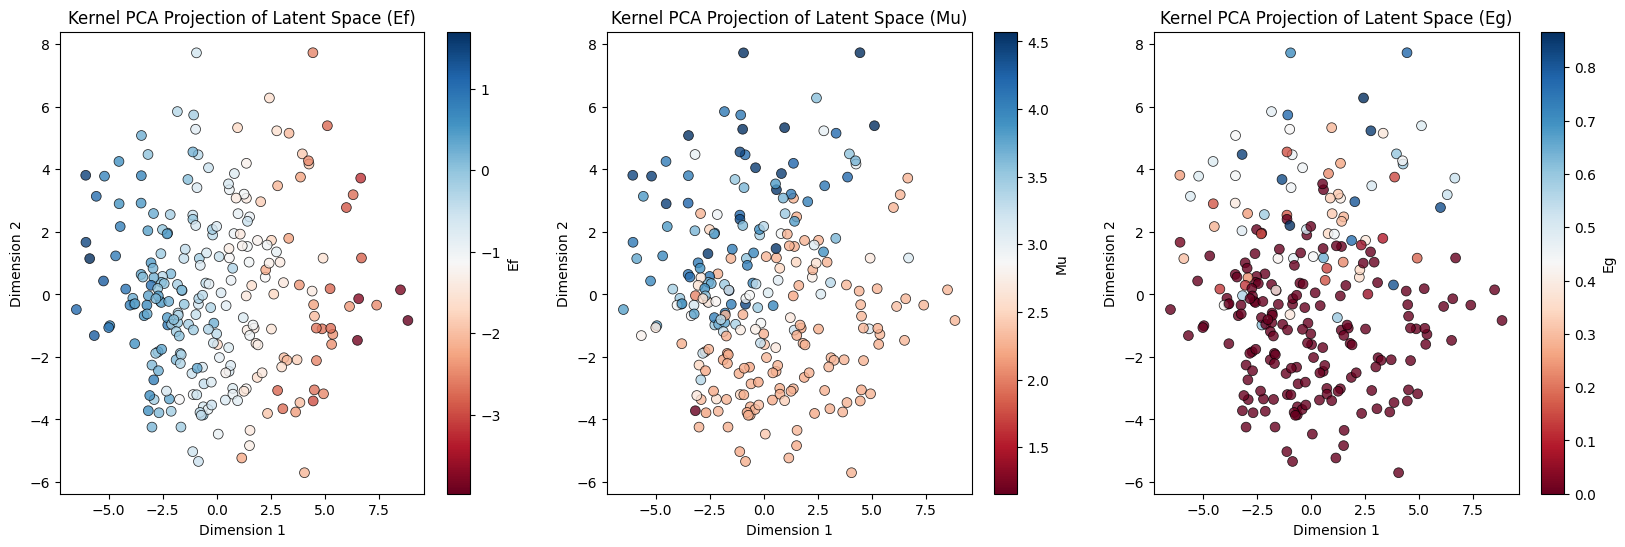

In [298]:
# Extract latent representations
encoder_model = Model(inputs = encoder_input, outputs = encoder_output)
latent_X = encoder_model.predict(X[:240,:])

# Apply Kernel PCA
kpca = KernelPCA(n_components=2, kernel='linear', gamma=None, fit_inverse_transform=True, alpha=1.0, n_jobs=-1)
kpca_embeddings = kpca.fit_transform(latent_X)

# Create a DataFrame for Seaborn
kpca_df = pd.DataFrame(data={'Dimension 1': kpca_embeddings[:, 0],
                             'Dimension 2': kpca_embeddings[:, 1],
                             'Ef': y['Ef_per_cell'],
                             'Mu': y['Mu_per_cell'],
                             'Eg': y['Eg']})

# Visualize the projected latent space using Seaborn
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
scatter_ef = sns.scatterplot(ax=ax[0], data=kpca_df, x='Dimension 1', y='Dimension 2', hue='Ef', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)
scatter_mu = sns.scatterplot(ax=ax[1], data=kpca_df, x='Dimension 1', y='Dimension 2', hue='Mu', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)
scatter_eg = sns.scatterplot(ax=ax[2], data=kpca_df, x='Dimension 1', y='Dimension 2', hue='Eg', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)

norm_ef = Normalize(vmin=kpca_df['Ef'].min(), vmax=kpca_df['Ef'].max())
norm_mu = Normalize(vmin=kpca_df['Mu'].min(), vmax=kpca_df['Mu'].max())
norm_eg = Normalize(vmin=kpca_df['Eg'].min(), vmax=kpca_df['Eg'].max())

sm_ef = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_ef)
sm_mu = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_mu)
sm_eg = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_eg)

sm_ef.set_array([])
sm_mu.set_array([])
sm_eg.set_array([])

cbar_ef = fig.colorbar(sm_ef, ax=ax[0])
cbar_mu = fig.colorbar(sm_mu, ax=ax[1])
cbar_eg = fig.colorbar(sm_eg, ax=ax[2])

cbar_ef.set_label('Ef')
cbar_mu.set_label('Mu')
cbar_eg.set_label('Eg')

ax[0].set_title('Kernel PCA Projection of Latent Space (Ef)')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')

ax[1].set_title('Kernel PCA Projection of Latent Space (Mu)')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')

ax[2].set_title('Kernel PCA Projection of Latent Space (Eg)')
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')

plt.show()

In [299]:
# !pip install optuna
# !pip install nbformat
import optuna
import optuna.importance
from optuna.visualization import plot_pareto_front, plot_param_importances, plot_parallel_coordinate, plot_intermediate_values

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [300]:
def optuna_HP(trial):
    
    # Hyperparameters to tune
    dropout_encoder = trial.suggest_float('dropout_encoder', 0.0, 0.2)
    dropout_ffnn = trial.suggest_float('dropout_ffnn', 0.0, 0.5)
#    reg_L1_encoder = trial.suggest_float('reg_L1_encocder', 1e-5, 0.5)
#    reg_L1_ffnn = trial.suggest_float('reg_L1_ffnn', 1e-5, 0.5)
#    reg_L2_encoder = trial.suggest_float('reg_L2_encocder', 1e-5, 0.5)
#    reg_L2_ffnn = trial.suggest_float('reg_L2_ffnn', 1e-5, 0.5)
    learning_rate = trial.suggest_float('learniing_rate', 1e-4, 1e-2)
    
    # Tune encoder layer dimensions
    input_dim = X_train.shape[1]
#    layer1_dim_encoder = trial.suggest_int('layer1_dim_encoder', 50, input_dim)
    latent_dim_encoder = trial.suggest_int('latent_dim_encoder', 50, input_dim)
    
    # Tune FFNN layer dimensions
    layer1_dim_ffnn = trial.suggest_int('layer1_dim_ffnn', 20, latent_dim_encoder)
#    layer2_dim_ffnn = trial.suggest_int('layer2_dim_ffnn', 5, layer1_dim_ffnn)
    
    # Tune activation function
    activation_funcn = trial.suggest_categorical('activation_funcn', ['elu', 'relu', 'selu'])
    
    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)
    
    # Model architecture
    encoder_input = keras.Input(shape = (input_dim,))
    encoder = Dropout(dropout_encoder)(encoder_input)
#    encoder = Dense(layer1_dim_encoder, activation=activation_funcn, kernel_regularizer=L1(reg_L1_encoder))(encoder)
#    encoder = Dropout(dropout_encoder)(encoder_input)
    encoder_output = Dense(latent_dim_encoder, activation=activation_funcn)(encoder)
    
    decoder = Dropout(dropout_encoder)(encoder_output)
    decoder_output = Dense(input_dim, activation = 'linear')(decoder)

    # autoencoder
    autoencoder = Model(inputs = encoder_input, outputs = decoder_output)
    autoencoder.compile(optimizer = Adam(learning_rate = learning_rate), loss=MeanSquaredError())    
    
    # FFNN
    ffnn_MBT_input = Dense(layer1_dim_ffnn, activation = activation_funcn)(encoder_output)
    ffnn_MBT = Dropout(dropout_ffnn)(ffnn_MBT_input)
#    ffnn_MBT = Dense(layer2_dim_ffnn, activation = activation_funcn)(ffnn_MBT_input)
#    ffnn_MBT = Dropout(dropout_ffnn)(ffnn_MBT)
    ffnn_MBT_output = Dense(3, activation = 'linear')(ffnn_MBT)

    # Combined model
    combined_output = [decoder_output, ffnn_MBT_output]
    combined_model = Model(inputs = encoder_input, outputs = combined_output)
    combined_model.compile(optimizer = optimizer, loss = [MeanSquaredError(), MeanAbsoluteError()], 
                           loss_weights = [1, 10], metrics = [MeanSquaredError, MeanAbsoluteError]) 

    # Training
    history = combined_model.fit(X_train, [X_train, y_train], validation_data = (X_val, [X_val, y_val]),
                                 epochs = 500, batch_size = 32,
                                 sample_weight = [mask_train, mask_train], verbose = 0)
    # callbacks = [EarlyStopping(patience = 100, min_delta = 0.001)],


    pred_val = combined_model.predict(X_val)
    
    r2_score_ef = metrics.r2_score(y_val[mask_val==1][:, 0], pred_val[1][mask_val==1][:,0])
    r2_score_mu = metrics.r2_score(y_val[mask_val==1][:, 1], pred_val[1][mask_val==1][:,1])
    r2_score_eg = metrics.r2_score(y_val[mask_val==1][:, 2], pred_val[1][mask_val==1][:,2])
    
    return r2_score_ef,r2_score_mu,r2_score_eg

In [301]:
# Create and optimize the study
study = optuna.create_study(directions = ['maximize','maximize','maximize'])
study.optimize(optuna_HP, n_trials=200)

[I 2024-06-07 15:09:31,534] A new study created in memory with name: no-name-ca378a97-4205-42aa-9eb5-c4f53b50ef6a


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:10:12,110] Trial 0 finished with values: [0.7047431647564736, 0.7228151795783644, 0.30921691494706705] and parameters: {'dropout_encoder': 0.07600963732055983, 'dropout_ffnn': 0.1334599059721816, 'learniing_rate': 0.009094776914409297, 'latent_dim_encoder': 90, 'layer1_dim_ffnn': 81, 'activation_funcn': 'relu'}. 


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021354848EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:10:52,522] Trial 1 finished with values: [0.7370401599362777, 0.633806612300219, 0.27369565372372795] and parameters: {'dropout_encoder': 0.06126444456180653, 'dropout_ffnn': 0.2277362812079829, 'learniing_rate': 0.0021963218982615847, 'latent_dim_encoder': 63, 'layer1_dim_ffnn': 62, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:11:32,418] Trial 2 finished with values: [0.8427624138132741, 0.6692643362380577, 0.2799827549632] and parameters: {'dropout_encoder': 0.11782214897691444, 'dropout_ffnn': 0.4824119044985584, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 65, 'layer1_dim_ffnn': 31, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:12:13,153] Trial 3 finished with values: [0.37710999237242715, 0.7867680315959202, -0.76380998227799] and parameters: {'dropout_encoder': 0.1300488660174058, 'dropout_ffnn': 0.19216972712901287, 'learniing_rate': 0.009478015168617326, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 89, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:12:53,215] Trial 4 finished with values: [0.8229844119374149, 0.7557629096331643, 0.2700735106195372] and parameters: {'dropout_encoder': 0.09418123913884963, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.006423969006894015, 'latent_dim_encoder': 63, 'layer1_dim_ffnn': 36, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:13:33,680] Trial 5 finished with values: [0.7789346606113287, 0.7838010589138381, 0.17151561797067572] and parameters: {'dropout_encoder': 0.04354771898418289, 'dropout_ffnn': 0.1909484533873601, 'learniing_rate': 0.009979686907118408, 'latent_dim_encoder': 77, 'layer1_dim_ffnn': 67, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2024-06-07 15:14:13,574] Trial 6 finished with values: [0.7828054690902426, 0.647319326791336, 0.41965643667186414] and parameters: {'dropout_encoder': 0.0764141345175011, 'dropout_ffnn': 0.326832431721691, 'learniing_rate': 0.0014279989270428934, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 28, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:14:53,138] Trial 7 finished with values: [0.7960608945483301, 0.7816884742440952, 0.5354320189507397] and parameters: {'dropout_encoder': 0.021179698760446633, 'dropout_ffnn': 0.3817092769143796, 'learniing_rate': 0.007621902432005883, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 31, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:15:33,268] Trial 8 finished with values: [0.838081688796019, 0.6954884366234426, 0.4191541825687991] and parameters: {'dropout_encoder': 0.05354145302076954, 'dropout_ffnn': 0.2913215812296373, 'learniing_rate': 0.0006652190873106253, 'latent_dim_encoder': 87, 'layer1_dim_ffnn': 40, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2024-06-07 15:16:15,668] Trial 9 finished with values: [0.8067194050424159, 0.7410059927922175, 0.4290743998136848] and parameters: {'dropout_encoder': 0.17952706934777343, 'dropout_ffnn': 0.2360103291664163, 'learniing_rate': 0.002947180459782262, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 20, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 15:16:59,605] Trial 10 finished with values: [0.8275860710473425, 0.6068381128839266, 0.10819255486228829] and parameters: {'dropout_encoder': 0.1392579442600084, 'dropout_ffnn': 0.34067295084398874, 'learniing_rate': 0.006072746405138332, 'latent_dim_encoder': 78, 'layer1_dim_ffnn': 67, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:17:41,399] Trial 11 finished with values: [0.8252877094234614, 0.7103649854289881, 0.4723123939543832] and parameters: {'dropout_encoder': 0.16932270357975324, 'dropout_ffnn': 0.24197890220482476, 'learniing_rate': 0.003233755908530829, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 27, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:18:22,139] Trial 12 finished with values: [0.8737037507032503, 0.7551600051288294, 0.29991183611232786] and parameters: {'dropout_encoder': 0.01979115672919718, 'dropout_ffnn': 0.13585794668675166, 'learniing_rate': 0.0022371348851121767, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 75, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:19:02,123] Trial 13 finished with values: [0.6505728787811245, 0.5978332071437364, 0.19598510287858306] and parameters: {'dropout_encoder': 0.1938679247915743, 'dropout_ffnn': 0.35473939380835606, 'learniing_rate': 0.0009763388936196797, 'latent_dim_encoder': 93, 'layer1_dim_ffnn': 31, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:19:41,967] Trial 14 finished with values: [0.8370797511227991, 0.6425111185205442, 0.5092250565827972] and parameters: {'dropout_encoder': 0.055512407777938005, 'dropout_ffnn': 0.030864694091136347, 'learniing_rate': 0.0007811589541458826, 'latent_dim_encoder': 59, 'layer1_dim_ffnn': 59, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:20:21,730] Trial 15 finished with values: [0.8751219860787854, 0.7788783588666452, 0.1747672783691686] and parameters: {'dropout_encoder': 0.042371732070048476, 'dropout_ffnn': 0.49953050490910933, 'learniing_rate': 0.003850986503494902, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 23, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:21:03,529] Trial 16 finished with values: [0.6811026991200039, 0.5476976136423582, 0.16588346911146834] and parameters: {'dropout_encoder': 0.08676178855922863, 'dropout_ffnn': 0.05955716900895919, 'learniing_rate': 0.0008006872257628828, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 83, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:21:44,025] Trial 17 finished with values: [0.8534798220530286, 0.8211569628635634, 0.34606079807300194] and parameters: {'dropout_encoder': 0.07889646573607896, 'dropout_ffnn': 0.1476240187589709, 'learniing_rate': 0.0033936958609323865, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 59, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:22:23,913] Trial 18 finished with values: [0.9162835458699842, 0.6652242235283733, 0.32443233643846636] and parameters: {'dropout_encoder': 0.004484415766268501, 'dropout_ffnn': 0.10868714153593667, 'learniing_rate': 0.003278423425978465, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 63, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:23:03,919] Trial 19 finished with values: [0.6522835400558047, 0.5249392259720036, -0.035575147453905664] and parameters: {'dropout_encoder': 0.12231480341808872, 'dropout_ffnn': 0.4366081541528029, 'learniing_rate': 0.009928067588242384, 'latent_dim_encoder': 62, 'layer1_dim_ffnn': 59, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:23:43,919] Trial 20 finished with values: [0.8056202623778813, 0.5346695604250831, -0.06691890014490554] and parameters: {'dropout_encoder': 0.04512205087383006, 'dropout_ffnn': 0.4390389764809657, 'learniing_rate': 0.008757866779914827, 'latent_dim_encoder': 87, 'layer1_dim_ffnn': 67, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:24:24,393] Trial 21 finished with values: [0.8197575757478687, 0.6908275022153318, 0.34432970195889556] and parameters: {'dropout_encoder': 0.11974563916048829, 'dropout_ffnn': 0.2650342408452947, 'learniing_rate': 0.005905240518827079, 'latent_dim_encoder': 81, 'layer1_dim_ffnn': 75, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:25:04,627] Trial 22 finished with values: [0.8726979863819289, 0.7818069501808296, 0.4260386908514139] and parameters: {'dropout_encoder': 0.008952473030525132, 'dropout_ffnn': 0.39339032909843924, 'learniing_rate': 0.0050159720139095, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 68, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:25:44,557] Trial 23 finished with values: [0.7218377834324484, 0.7874985051722843, -1.0988522641747585] and parameters: {'dropout_encoder': 0.15653362297567297, 'dropout_ffnn': 0.18138287079481757, 'learniing_rate': 0.009104118663710555, 'latent_dim_encoder': 87, 'layer1_dim_ffnn': 54, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:26:23,775] Trial 24 finished with values: [0.8032648692519321, 0.6369663014190701, 0.27004889487139516] and parameters: {'dropout_encoder': 0.13431118039024903, 'dropout_ffnn': 0.36043370650542705, 'learniing_rate': 0.004216535687253222, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 33, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:27:03,658] Trial 25 finished with values: [0.749688890142865, 0.8167905918773277, 0.02058725075081491] and parameters: {'dropout_encoder': 0.07257910096767554, 'dropout_ffnn': 0.43422570706935726, 'learniing_rate': 0.0072802736444104515, 'latent_dim_encoder': 76, 'layer1_dim_ffnn': 60, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:27:43,382] Trial 26 finished with values: [0.8075618819590273, 0.8206266808808373, 0.371613987582165] and parameters: {'dropout_encoder': 0.1542007222815588, 'dropout_ffnn': 0.18931217020925628, 'learniing_rate': 0.005245831013439756, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 24, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:28:23,330] Trial 27 finished with values: [0.5929688833087223, 0.6337027624589043, 0.21852522136311647] and parameters: {'dropout_encoder': 0.15679112571967327, 'dropout_ffnn': 0.2692329531881806, 'learniing_rate': 0.0094925010527374, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 44, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:29:02,944] Trial 28 finished with values: [0.7441603548819773, 0.6782789869766028, 0.24054705093763218] and parameters: {'dropout_encoder': 0.053638024591398596, 'dropout_ffnn': 0.47562347020605117, 'learniing_rate': 0.00674105159822339, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 50, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:29:42,493] Trial 29 finished with values: [0.7579606513516167, 0.5893147877130738, -0.08088272471444435] and parameters: {'dropout_encoder': 0.06659835389119238, 'dropout_ffnn': 0.4275003614065586, 'learniing_rate': 0.006685001841059327, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 21, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:30:21,658] Trial 30 finished with values: [0.7727106619246387, 0.7648004621791906, 0.44003526246879154] and parameters: {'dropout_encoder': 0.1791220967001529, 'dropout_ffnn': 0.4102105719761001, 'learniing_rate': 0.0034441272982541423, 'latent_dim_encoder': 52, 'layer1_dim_ffnn': 21, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:31:01,852] Trial 31 finished with values: [0.8254861078359954, 0.6784053805131898, -0.41698240319471647] and parameters: {'dropout_encoder': 0.022096707958120312, 'dropout_ffnn': 0.1471357321726166, 'learniing_rate': 0.009207162966005846, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 79, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:31:41,606] Trial 32 finished with values: [0.8125587064860695, 0.5369021374509056, 0.3857751975580338] and parameters: {'dropout_encoder': 0.023201780999502476, 'dropout_ffnn': 0.068417858697981, 'learniing_rate': 0.008729856054008927, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 50, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:32:21,914] Trial 33 finished with values: [0.7893857837172211, 0.8146163252562555, 0.5150650746953633] and parameters: {'dropout_encoder': 0.02919518424734695, 'dropout_ffnn': 0.203150251534167, 'learniing_rate': 0.008931183078534943, 'latent_dim_encoder': 74, 'layer1_dim_ffnn': 24, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:33:01,742] Trial 34 finished with values: [0.6206861518069746, 0.6396312765553052, -0.14150172783960513] and parameters: {'dropout_encoder': 0.1413621698411592, 'dropout_ffnn': 0.36745850422677606, 'learniing_rate': 0.009130135167059222, 'latent_dim_encoder': 78, 'layer1_dim_ffnn': 51, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:33:41,562] Trial 35 finished with values: [0.7346729182149003, 0.6031434020293629, 0.19028233976140796] and parameters: {'dropout_encoder': 0.11218431809388485, 'dropout_ffnn': 0.332062424381626, 'learniing_rate': 0.0022076406272200505, 'latent_dim_encoder': 73, 'layer1_dim_ffnn': 41, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:34:21,401] Trial 36 finished with values: [0.8549406455660364, 0.5739832260369349, 0.21460039514752693] and parameters: {'dropout_encoder': 0.10787211198422747, 'dropout_ffnn': 0.46120977215209624, 'learniing_rate': 0.0003008876906862615, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 66, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:35:01,425] Trial 37 finished with values: [0.8339804527836673, 0.7040366087534015, 0.37524812030214105] and parameters: {'dropout_encoder': 0.04971961821325326, 'dropout_ffnn': 0.13603199516487752, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 96, 'layer1_dim_ffnn': 25, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:35:41,166] Trial 38 finished with values: [0.7062985652615383, 0.7761661665027196, 0.008599470096579576] and parameters: {'dropout_encoder': 0.11547889814903584, 'dropout_ffnn': 0.3907587509551617, 'learniing_rate': 0.00828936810783961, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 20, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:36:20,757] Trial 39 finished with values: [0.822348742636415, 0.6664601423788687, 0.43669927990653534] and parameters: {'dropout_encoder': 0.01355665341028476, 'dropout_ffnn': 0.008464891416675668, 'learniing_rate': 0.001441724274841792, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 37, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:36:59,928] Trial 40 finished with values: [0.8406018662421698, 0.7472993545451763, 0.2743048136983717] and parameters: {'dropout_encoder': 0.13835752590791373, 'dropout_ffnn': 0.07305818105121276, 'learniing_rate': 0.0028024053948475457, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 51, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:37:39,707] Trial 41 finished with values: [0.8079224209803412, 0.5728625704821891, 0.19476184955037124] and parameters: {'dropout_encoder': 0.06622676601975915, 'dropout_ffnn': 0.09531803774134928, 'learniing_rate': 0.009751686395529664, 'latent_dim_encoder': 96, 'layer1_dim_ffnn': 43, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:38:21,646] Trial 42 finished with values: [0.8055572863641939, 0.6621208039713264, -0.9910102439815016] and parameters: {'dropout_encoder': 0.07550973578136971, 'dropout_ffnn': 0.3017826723385336, 'learniing_rate': 0.007098205268901406, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 65, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:39:01,854] Trial 43 finished with values: [0.8209084614817069, 0.830262791542178, 0.45071630288588516] and parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.2090063738283351, 'learniing_rate': 0.0036038736198583496, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 40, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:39:42,069] Trial 44 finished with values: [0.7665104550560797, 0.5831599707708471, -0.05583307624035627] and parameters: {'dropout_encoder': 0.035989300574063424, 'dropout_ffnn': 0.16503978055589652, 'learniing_rate': 0.00971521974448935, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 31, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:40:22,420] Trial 45 finished with values: [0.8132790484990982, 0.7129062975964944, 0.372390419287164] and parameters: {'dropout_encoder': 0.060962943260132324, 'dropout_ffnn': 0.011637956775554292, 'learniing_rate': 0.009562760305361849, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 34, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:41:03,015] Trial 46 finished with values: [0.8714856992468163, 0.7752803439538216, 0.44840032515872996] and parameters: {'dropout_encoder': 0.021220188221942937, 'dropout_ffnn': 0.1448753665582151, 'learniing_rate': 0.0009555305820591598, 'latent_dim_encoder': 97, 'layer1_dim_ffnn': 48, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:41:43,236] Trial 47 finished with values: [0.7992044510703453, 0.49125940301347437, 0.360620439896445] and parameters: {'dropout_encoder': 0.09221349772650322, 'dropout_ffnn': 0.07840740310286731, 'learniing_rate': 0.007955480716136089, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 44, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 15:42:23,080] Trial 48 finished with values: [0.6680750888353799, 0.6209691095735086, -0.14936272737097211] and parameters: {'dropout_encoder': 0.09943156264175168, 'dropout_ffnn': 0.1229538722370474, 'learniing_rate': 0.007619457312268036, 'latent_dim_encoder': 59, 'layer1_dim_ffnn': 50, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:43:03,423] Trial 49 finished with values: [0.6576481946395527, 0.3065869706641403, 0.30846197177409096] and parameters: {'dropout_encoder': 0.10209799884501175, 'dropout_ffnn': 0.1438689199489298, 'learniing_rate': 0.0005850224122297697, 'latent_dim_encoder': 56, 'layer1_dim_ffnn': 47, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:43:43,670] Trial 50 finished with values: [0.7416236077092093, 0.793066621320927, 0.2753196258084988] and parameters: {'dropout_encoder': 0.16711439648804913, 'dropout_ffnn': 0.2650342408452947, 'learniing_rate': 0.005867187605495333, 'latent_dim_encoder': 81, 'layer1_dim_ffnn': 49, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:44:24,292] Trial 51 finished with values: [0.7019645759096702, 0.614191392865565, 0.17977580509665192] and parameters: {'dropout_encoder': 0.17952706934777343, 'dropout_ffnn': 0.43422570706935726, 'learniing_rate': 0.005305438848743098, 'latent_dim_encoder': 87, 'layer1_dim_ffnn': 69, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:45:04,469] Trial 52 finished with values: [0.760785590169707, 0.6975720665189145, 0.060158263761261654] and parameters: {'dropout_encoder': 0.04512205087383006, 'dropout_ffnn': 0.332062424381626, 'learniing_rate': 0.007064171207885355, 'latent_dim_encoder': 87, 'layer1_dim_ffnn': 74, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 15:45:44,293] Trial 53 finished with values: [0.7358889534153241, 0.759821277463472, 0.1467277968374917] and parameters: {'dropout_encoder': 0.03065585451557189, 'dropout_ffnn': 0.3017826723385336, 'learniing_rate': 0.003683055488856049, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 22, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:46:23,967] Trial 54 finished with values: [0.6746529360737968, 0.690558203601856, 0.28828241976235736] and parameters: {'dropout_encoder': 0.17952706934777343, 'dropout_ffnn': 0.2360103291664163, 'learniing_rate': 0.00765673945528417, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 52, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:47:03,718] Trial 55 finished with values: [0.8049653492985084, 0.8271452744258294, -0.3854952390074047] and parameters: {'dropout_encoder': 0.02919518424734695, 'dropout_ffnn': 0.2913215812296373, 'learniing_rate': 0.008931183078534943, 'latent_dim_encoder': 74, 'layer1_dim_ffnn': 59, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:47:43,370] Trial 56 finished with values: [0.8401925022715013, 0.6949252344879331, 0.46212912122262195] and parameters: {'dropout_encoder': 0.07600963732055983, 'dropout_ffnn': 0.1334599059721816, 'learniing_rate': 0.009344502806441486, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 53, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:48:23,899] Trial 57 finished with values: [0.8862474099767305, 0.7788015785952689, 0.3795913015770618] and parameters: {'dropout_encoder': 0.021220188221942937, 'dropout_ffnn': 0.1448753665582151, 'learniing_rate': 0.0009555305820591598, 'latent_dim_encoder': 97, 'layer1_dim_ffnn': 91, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:49:02,896] Trial 58 finished with values: [0.8601555972299876, 0.6794814333581309, 0.40999405207228756] and parameters: {'dropout_encoder': 0.04971961821325326, 'dropout_ffnn': 0.13603199516487752, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 29, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:49:42,539] Trial 59 finished with values: [0.765961252162711, 0.7314768835957877, 0.4676993963700996] and parameters: {'dropout_encoder': 0.19629994249605162, 'dropout_ffnn': 0.18931217020925628, 'learniing_rate': 0.005245831013439756, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 59, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:50:22,118] Trial 60 finished with values: [0.7248791400596113, 0.5511454167476466, 0.5089697602416328] and parameters: {'dropout_encoder': 0.11432641080621093, 'dropout_ffnn': 0.10868714153593667, 'learniing_rate': 0.009207162966005846, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 30, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:51:01,895] Trial 61 finished with values: [0.7257929185488898, 0.6133281302123517, -0.18541972712206434] and parameters: {'dropout_encoder': 0.01979115672919718, 'dropout_ffnn': 0.1999796194752419, 'learniing_rate': 0.007098205268901406, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 21, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:51:41,318] Trial 62 finished with values: [0.542954288079968, -0.1249484343722218, -0.0877352724298266] and parameters: {'dropout_encoder': 0.029328728635840618, 'dropout_ffnn': 0.4824119044985584, 'learniing_rate': 0.00011645277386684348, 'latent_dim_encoder': 59, 'layer1_dim_ffnn': 47, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:52:20,781] Trial 63 finished with values: [0.7595785295631163, 0.8366777848031219, 0.47575397104250106] and parameters: {'dropout_encoder': 0.09221349772650322, 'dropout_ffnn': 0.07840740310286731, 'learniing_rate': 0.007955480716136089, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 51, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 15:53:00,089] Trial 64 finished with values: [0.5507935997395867, 0.6130557672104694, -0.19768122922470255] and parameters: {'dropout_encoder': 0.06622676601975915, 'dropout_ffnn': 0.4269482190823548, 'learniing_rate': 0.009104118663710555, 'latent_dim_encoder': 62, 'layer1_dim_ffnn': 62, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:53:40,288] Trial 65 finished with values: [0.7863167614388481, 0.7460851942020266, -2.84944635477013] and parameters: {'dropout_encoder': 0.11782214897691444, 'dropout_ffnn': 0.4824119044985584, 'learniing_rate': 0.009751686395529664, 'latent_dim_encoder': 96, 'layer1_dim_ffnn': 91, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:54:19,555] Trial 66 finished with values: [0.8832953800805917, 0.7377333968115611, 0.44146480323956105] and parameters: {'dropout_encoder': 0.01979115672919718, 'dropout_ffnn': 0.13585794668675166, 'learniing_rate': 0.0022371348851121767, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 24, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:54:58,756] Trial 67 finished with values: [0.8012534618263655, 0.8169821190933171, 0.5572435823343697] and parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 44, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:55:38,189] Trial 68 finished with values: [0.7247644392131836, 0.5066482820697615, 0.1605196741322774] and parameters: {'dropout_encoder': 0.10209799884501175, 'dropout_ffnn': 0.1438689199489298, 'learniing_rate': 0.0005850224122297697, 'latent_dim_encoder': 56, 'layer1_dim_ffnn': 51, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 15:56:18,039] Trial 69 finished with values: [0.8544574020586151, 0.6282428248130394, 0.3255635180360372] and parameters: {'dropout_encoder': 0.05003353959929422, 'dropout_ffnn': 0.34067295084398874, 'learniing_rate': 0.006072746405138332, 'latent_dim_encoder': 88, 'layer1_dim_ffnn': 43, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:56:57,852] Trial 70 finished with values: [0.742151737764188, 0.4192190096439087, 0.23424560961997776] and parameters: {'dropout_encoder': 0.08676178855922863, 'dropout_ffnn': 0.05955716900895919, 'learniing_rate': 0.0008006872257628828, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 64, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:57:37,527] Trial 71 finished with values: [0.8651194698720855, 0.6608156322452711, 0.25057140205211403] and parameters: {'dropout_encoder': 0.021179698760446633, 'dropout_ffnn': 0.3817092769143796, 'learniing_rate': 0.005905240518827079, 'latent_dim_encoder': 81, 'layer1_dim_ffnn': 64, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:58:19,236] Trial 72 finished with values: [0.790279326443343, 0.7353067969463907, 0.25454986911177246] and parameters: {'dropout_encoder': 0.07550973578136971, 'dropout_ffnn': 0.3017826723385336, 'learniing_rate': 0.007098205268901406, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 25, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 15:58:59,017] Trial 73 finished with values: [0.764347146885118, 0.7766051907762683, 0.15146416875844837] and parameters: {'dropout_encoder': 0.11782214897691444, 'dropout_ffnn': 0.4102105719761001, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 65, 'layer1_dim_ffnn': 57, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 15:59:38,858] Trial 74 finished with values: [0.8833730359209698, 0.7401144578794454, 0.24621000539827165] and parameters: {'dropout_encoder': 0.021179698760446633, 'dropout_ffnn': 0.19305503386329476, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 24, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:00:18,967] Trial 75 finished with values: [0.8670065325397959, 0.7039426976153458, 0.3504365604118501] and parameters: {'dropout_encoder': 0.10787211198422747, 'dropout_ffnn': 0.46120977215209624, 'learniing_rate': 0.0005844936712510034, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 56, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:00:58,773] Trial 76 finished with values: [0.8303805668073817, 0.7287539791849658, 0.6035484129058032] and parameters: {'dropout_encoder': 0.13835752590791373, 'dropout_ffnn': 0.07305818105121276, 'learniing_rate': 0.0028024053948475457, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 40, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:01:38,828] Trial 77 finished with values: [0.8627608827985616, 0.7664043602427948, 0.23803485175501404] and parameters: {'dropout_encoder': 0.053638024591398596, 'dropout_ffnn': 0.36043370650542705, 'learniing_rate': 0.0052768457931150455, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 47, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:02:18,262] Trial 78 finished with values: [0.7133707421698532, 0.7521294558998289, 0.18376479385662148] and parameters: {'dropout_encoder': 0.09943156264175168, 'dropout_ffnn': 0.39339032909843924, 'learniing_rate': 0.007619457312268036, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 34, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:02:58,311] Trial 79 finished with values: [0.7903077252799328, 0.7611533840116815, 0.6070880555875966] and parameters: {'dropout_encoder': 0.023201780999502476, 'dropout_ffnn': 0.068417858697981, 'learniing_rate': 0.00828936810783961, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 31, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:03:37,711] Trial 80 finished with values: [0.7089700810843378, 0.6785724966856668, 0.08161248196174287] and parameters: {'dropout_encoder': 0.12595965102866044, 'dropout_ffnn': 0.4824119044985584, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 65, 'layer1_dim_ffnn': 21, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:04:18,099] Trial 81 finished with values: [0.8928029043829948, 0.7696408901922005, 0.44665458246412926] and parameters: {'dropout_encoder': 0.008952473030525132, 'dropout_ffnn': 0.030864694091136347, 'learniing_rate': 0.006506734872872367, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 32, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 16:04:58,062] Trial 82 finished with values: [0.6559390659652298, 0.7469026731048712, 0.06795259520089592] and parameters: {'dropout_encoder': 0.11974563916048829, 'dropout_ffnn': 0.17210326970354073, 'learniing_rate': 0.009751686395529664, 'latent_dim_encoder': 96, 'layer1_dim_ffnn': 56, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:05:37,833] Trial 83 finished with values: [0.7934234545952183, 0.6766520965281235, -0.5157618568048477] and parameters: {'dropout_encoder': 0.10787211198422747, 'dropout_ffnn': 0.49953050490910933, 'learniing_rate': 0.007913190847382304, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 71, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:06:17,627] Trial 84 finished with values: [0.662800407327576, 0.5385328206357168, -0.008838939723443406] and parameters: {'dropout_encoder': 0.15679112571967327, 'dropout_ffnn': 0.18931217020925628, 'learniing_rate': 0.0094925010527374, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 51, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:06:57,439] Trial 85 finished with values: [0.7147702539781036, 0.8329402025277717, 0.3425780541310953] and parameters: {'dropout_encoder': 0.11974563916048829, 'dropout_ffnn': 0.09857697576848007, 'learniing_rate': 0.005905240518827079, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 20, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 16:07:36,820] Trial 86 finished with values: [0.7396091124361819, 0.7880579006851698, 0.44796580119709806] and parameters: {'dropout_encoder': 0.10209799884501175, 'dropout_ffnn': 0.1438689199489298, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 32, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:08:15,962] Trial 87 finished with values: [0.8421924091051228, 0.7961980705803005, 0.5198868047771088] and parameters: {'dropout_encoder': 0.09418123913884963, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.006423969006894015, 'latent_dim_encoder': 63, 'layer1_dim_ffnn': 32, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 16:08:55,284] Trial 88 finished with values: [0.765743552754302, 0.6254302457967569, -0.005833165544076646] and parameters: {'dropout_encoder': 0.1413621698411592, 'dropout_ffnn': 0.36745850422677606, 'learniing_rate': 0.002575750099173905, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 58, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:09:35,274] Trial 89 finished with values: [0.8166816034232196, 0.7895593569675003, 0.08953130486829597] and parameters: {'dropout_encoder': 0.07257910096767554, 'dropout_ffnn': 0.027356756512451785, 'learniing_rate': 0.0072802736444104515, 'latent_dim_encoder': 78, 'layer1_dim_ffnn': 64, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:10:14,731] Trial 90 finished with values: [0.7505874509674229, 0.5871308993330195, 0.31147818769585167] and parameters: {'dropout_encoder': 0.055762516612722496, 'dropout_ffnn': 0.1476240187589709, 'learniing_rate': 0.009478015168617326, 'latent_dim_encoder': 88, 'layer1_dim_ffnn': 42, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:10:54,430] Trial 91 finished with values: [0.7739260733445081, 0.74510264632438, 0.5488742828362876] and parameters: {'dropout_encoder': 0.08537970396646122, 'dropout_ffnn': 0.2090063738283351, 'learniing_rate': 0.0036038736198583496, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 53, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:11:34,195] Trial 92 finished with values: [0.8362687474703252, 0.7429432577838023, 0.4378867551635762] and parameters: {'dropout_encoder': 0.02919518424734695, 'dropout_ffnn': 0.203150251534167, 'learniing_rate': 0.007955480716136089, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 20, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:12:14,205] Trial 93 finished with values: [0.5915528611525822, 0.5143963093532026, 0.29315131677558925] and parameters: {'dropout_encoder': 0.15653362297567297, 'dropout_ffnn': 0.18138287079481757, 'learniing_rate': 0.009104118663710555, 'latent_dim_encoder': 87, 'layer1_dim_ffnn': 70, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:12:54,010] Trial 94 finished with values: [0.8108650073565506, 0.6707939256114633, -0.10752410458484207] and parameters: {'dropout_encoder': 0.07257910096767554, 'dropout_ffnn': 0.43422570706935726, 'learniing_rate': 0.0072802736444104515, 'latent_dim_encoder': 76, 'layer1_dim_ffnn': 64, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:13:33,963] Trial 95 finished with values: [0.7920356498609707, 0.632119402418094, 0.0423188763243717] and parameters: {'dropout_encoder': 0.07550973578136971, 'dropout_ffnn': 0.3017826723385336, 'learniing_rate': 0.007098205268901406, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 50, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:14:13,858] Trial 96 finished with values: [0.9296390905106622, 0.7453558491357215, 0.3606789877782717] and parameters: {'dropout_encoder': 0.004484415766268501, 'dropout_ffnn': 0.41984374479951647, 'learniing_rate': 0.002947180459782262, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 80, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:14:53,026] Trial 97 finished with values: [0.8548552920756666, 0.721568092701756, 0.22958267977193747] and parameters: {'dropout_encoder': 0.01979115672919718, 'dropout_ffnn': 0.4383020323906202, 'learniing_rate': 0.0036038736198583496, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 21, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:15:32,939] Trial 98 finished with values: [0.8604115513587574, 0.6296694899575697, 0.23342305221505977] and parameters: {'dropout_encoder': 0.014267508602246126, 'dropout_ffnn': 0.07840740310286731, 'learniing_rate': 0.009979686907118408, 'latent_dim_encoder': 77, 'layer1_dim_ffnn': 25, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2024-06-07 16:16:17,798] Trial 99 finished with values: [0.7185353556959502, 0.5420902711363553, 0.3619610088852421] and parameters: {'dropout_encoder': 0.06622676601975915, 'dropout_ffnn': 0.09531803774134928, 'learniing_rate': 0.009751686395529664, 'latent_dim_encoder': 96, 'layer1_dim_ffnn': 60, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 16:16:59,471] Trial 100 finished with values: [0.7555302076774212, 0.6399427701711475, -0.11306367268275164] and parameters: {'dropout_encoder': 0.008952473030525132, 'dropout_ffnn': 0.39339032909843924, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 27, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 16:17:39,833] Trial 101 finished with values: [0.8577622503881088, 0.6878870993579391, 0.24676045726346219] and parameters: {'dropout_encoder': 0.042371732070048476, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.006423969006894015, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 49, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:18:19,905] Trial 102 finished with values: [0.7566006043325519, 0.691129243329239, -0.37112500644210256] and parameters: {'dropout_encoder': 0.11432641080621093, 'dropout_ffnn': 0.04602986115804164, 'learniing_rate': 0.009207162966005846, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 67, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:18:59,847] Trial 103 finished with values: [0.8453582109172975, 0.7488496698882565, 0.3691567344036354] and parameters: {'dropout_encoder': 0.04971961821325326, 'dropout_ffnn': 0.3817092769143796, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 81, 'layer1_dim_ffnn': 81, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 16:19:39,719] Trial 104 finished with values: [0.895512938348502, 0.7048434043786376, 0.4478249593441902] and parameters: {'dropout_encoder': 0.008952473030525132, 'dropout_ffnn': 0.17287184635712277, 'learniing_rate': 0.0050159720139095, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 23, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:20:19,248] Trial 105 finished with values: [0.7840483945102703, 0.6635742112592562, 0.5537218870267198] and parameters: {'dropout_encoder': 0.06386084683932165, 'dropout_ffnn': 0.07840740310286731, 'learniing_rate': 0.008063371554359948, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 23, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:20:59,657] Trial 106 finished with values: [0.7876633719686649, 0.7752399261445563, -0.3949684201796697] and parameters: {'dropout_encoder': 0.09418123913884963, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.00926273164265129, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 64, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:21:38,644] Trial 107 finished with values: [0.8109698411100625, 0.6997329474530964, 0.36953465802335117] and parameters: {'dropout_encoder': 0.16168605762532973, 'dropout_ffnn': 0.13585794668675166, 'learniing_rate': 0.0028024053948475457, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 37, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 16:22:20,186] Trial 108 finished with values: [0.6162626604403947, 0.62656185409249, -0.03736935016700205] and parameters: {'dropout_encoder': 0.10787211198422747, 'dropout_ffnn': 0.46120977215209624, 'learniing_rate': 0.009772035468972802, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 29, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 16:23:00,253] Trial 109 finished with values: [0.9115065642979734, 0.6878612990501409, 0.17174942778894664] and parameters: {'dropout_encoder': 0.008952473030525132, 'dropout_ffnn': 0.23962255997847348, 'learniing_rate': 0.007221854730500751, 'latent_dim_encoder': 50, 'layer1_dim_ffnn': 47, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 16:23:40,244] Trial 110 finished with values: [0.8236881824535189, 0.5997175862369525, 0.12608499433989884] and parameters: {'dropout_encoder': 0.09221349772650322, 'dropout_ffnn': 0.24442279519371402, 'learniing_rate': 0.007955480716136089, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 55, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:24:19,989] Trial 111 finished with values: [0.9175720895391739, 0.6797539398656144, 0.466423342163087] and parameters: {'dropout_encoder': 0.01979115672919718, 'dropout_ffnn': 0.1476240187589709, 'learniing_rate': 0.0022371348851121767, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 22, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:24:59,900] Trial 112 finished with values: [0.771882976624439, 0.5425082573504434, 0.4638289752110276] and parameters: {'dropout_encoder': 0.09938419852646213, 'dropout_ffnn': 0.030864694091136347, 'learniing_rate': 0.006506734872872367, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 53, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:25:40,077] Trial 113 finished with values: [0.9061136925761353, 0.7271354353386266, 0.3443432284102913] and parameters: {'dropout_encoder': 0.02919518424734695, 'dropout_ffnn': 0.203150251534167, 'learniing_rate': 0.0017344413368184438, 'latent_dim_encoder': 87, 'layer1_dim_ffnn': 51, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 16:26:19,985] Trial 114 finished with values: [0.7523180737508801, 0.8595271315999278, 0.2483449659975444] and parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.006221874239730179, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 75, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:26:59,472] Trial 115 finished with values: [0.7192958882389928, 0.8433122855812791, 0.3342382634134127] and parameters: {'dropout_encoder': 0.16932270357975324, 'dropout_ffnn': 0.24197890220482476, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 35, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:27:38,822] Trial 116 finished with values: [0.7546658614101487, 0.7971099243162504, 0.17355177987728676] and parameters: {'dropout_encoder': 0.15667534284998524, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.006423969006894015, 'latent_dim_encoder': 63, 'layer1_dim_ffnn': 32, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:28:19,029] Trial 117 finished with values: [0.8017541822641224, 0.5904044275057772, 0.409086359948586] and parameters: {'dropout_encoder': 0.07889646573607896, 'dropout_ffnn': 0.23010838163423747, 'learniing_rate': 0.007621902432005883, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 32, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:28:58,436] Trial 118 finished with values: [0.7880464916334888, 0.6567327456456915, 0.324869833749578] and parameters: {'dropout_encoder': 0.19629994249605162, 'dropout_ffnn': 0.3453502365086096, 'learniing_rate': 0.0006652190873106253, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 28, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:29:37,879] Trial 119 finished with values: [0.8535405775430107, 0.7835487832738601, 0.46065074606147105] and parameters: {'dropout_encoder': 0.004073738236163749, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.007254712312741657, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 21, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:30:17,639] Trial 120 finished with values: [0.7648512144093984, 0.6639425524734145, 0.3226171300831545] and parameters: {'dropout_encoder': 0.023201780999502476, 'dropout_ffnn': 0.3807047508413125, 'learniing_rate': 0.005905240518827079, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 28, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:30:57,686] Trial 121 finished with values: [0.8251267520123731, 0.7534552518205644, 0.4037681048299937] and parameters: {'dropout_encoder': 0.12153327769842069, 'dropout_ffnn': 0.24197890220482476, 'learniing_rate': 0.003233755908530829, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 47, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:31:37,763] Trial 122 finished with values: [0.7901472829695914, 0.7636833571233643, 0.3879458906330715] and parameters: {'dropout_encoder': 0.02071002126583057, 'dropout_ffnn': 0.1334599059721816, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 95, 'layer1_dim_ffnn': 50, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:32:17,381] Trial 123 finished with values: [0.8497519462370937, 0.7081424626614177, 0.4101476574526216] and parameters: {'dropout_encoder': 0.01355665341028476, 'dropout_ffnn': 0.2090063738283351, 'learniing_rate': 0.001441724274841792, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 29, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:32:57,356] Trial 124 finished with values: [0.7708125587187503, 0.7591523722261404, 0.3784268859812572] and parameters: {'dropout_encoder': 0.13063747110835136, 'dropout_ffnn': 0.2650342408452947, 'learniing_rate': 0.003649456904909096, 'latent_dim_encoder': 81, 'layer1_dim_ffnn': 73, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:33:37,518] Trial 125 finished with values: [0.7971788503349214, 0.6830189788015023, -0.12426993344315318] and parameters: {'dropout_encoder': 0.1946765438825658, 'dropout_ffnn': 0.1909484533873601, 'learniing_rate': 0.009979686907118408, 'latent_dim_encoder': 77, 'layer1_dim_ffnn': 45, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:34:17,104] Trial 126 finished with values: [0.855507571140028, 0.6980168083846846, 0.4457878334364278] and parameters: {'dropout_encoder': 0.04971961821325326, 'dropout_ffnn': 0.203150251534167, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 27, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 16:34:56,586] Trial 127 finished with values: [0.8422061303126901, 0.7442415648804241, 0.48342013741830037] and parameters: {'dropout_encoder': 0.04971961821325326, 'dropout_ffnn': 0.08968605336879715, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 42, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:35:36,074] Trial 128 finished with values: [0.7448434251173321, 0.6980765111387495, -0.0569659580913906] and parameters: {'dropout_encoder': 0.0764141345175011, 'dropout_ffnn': 0.48977681915986016, 'learniing_rate': 0.0033936958609323865, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 53, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:36:15,813] Trial 129 finished with values: [0.8310377720929483, 0.6709182255138012, 0.30721766727722055] and parameters: {'dropout_encoder': 0.055512407777938005, 'dropout_ffnn': 0.3962800786698103, 'learniing_rate': 0.0007811589541458826, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 43, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:36:55,933] Trial 130 finished with values: [0.7048972733070722, 0.721701778444372, 0.13523751002417572] and parameters: {'dropout_encoder': 0.17219262257943369, 'dropout_ffnn': 0.1448753665582151, 'learniing_rate': 0.008931183078534943, 'latent_dim_encoder': 97, 'layer1_dim_ffnn': 50, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:37:35,379] Trial 131 finished with values: [0.8390127565563446, 0.7604103490861275, 0.3145671950703808] and parameters: {'dropout_encoder': 0.021220188221942937, 'dropout_ffnn': 0.41984374479951647, 'learniing_rate': 0.002947180459782262, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 43, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:38:15,370] Trial 132 finished with values: [0.7033142156253478, 0.7631817688199075, 0.27104100481147153] and parameters: {'dropout_encoder': 0.1791220967001529, 'dropout_ffnn': 0.4102105719761001, 'learniing_rate': 0.0034441272982541423, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 76, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:38:55,223] Trial 133 finished with values: [0.8323225740249279, 0.7249282564370929, 0.3740141632430436] and parameters: {'dropout_encoder': 0.004484415766268501, 'dropout_ffnn': 0.13585794668675166, 'learniing_rate': 0.005787569300770691, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 75, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:39:34,884] Trial 134 finished with values: [0.9071265771677642, 0.6874014112841355, 0.24565479160210224] and parameters: {'dropout_encoder': 0.004484415766268501, 'dropout_ffnn': 0.41984374479951647, 'learniing_rate': 0.004650168110140358, 'latent_dim_encoder': 63, 'layer1_dim_ffnn': 59, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:40:14,386] Trial 135 finished with values: [0.8289230187396115, 0.6826037419461397, 0.4773838596747265] and parameters: {'dropout_encoder': 0.049966038079215985, 'dropout_ffnn': 0.062327708225391465, 'learniing_rate': 0.006423969006894015, 'latent_dim_encoder': 63, 'layer1_dim_ffnn': 61, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:40:53,634] Trial 136 finished with values: [0.9224777511950851, 0.7909562640403538, 0.2894330559415703] and parameters: {'dropout_encoder': 0.004484415766268501, 'dropout_ffnn': 0.1909484533873601, 'learniing_rate': 0.003278423425978465, 'latent_dim_encoder': 77, 'layer1_dim_ffnn': 43, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 16:41:33,348] Trial 137 finished with values: [0.7910718264075471, 0.7066335541728773, 0.08437245877857258] and parameters: {'dropout_encoder': 0.09418123913884963, 'dropout_ffnn': 0.2090063738283351, 'learniing_rate': 0.008760384146281506, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 23, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 16:42:12,735] Trial 138 finished with values: [0.8543127164890364, 0.7181706319723797, 0.21173649354962565] and parameters: {'dropout_encoder': 0.021179698760446633, 'dropout_ffnn': 0.3817092769143796, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 20, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:42:52,213] Trial 139 finished with values: [0.8730749761008443, 0.7881746824357655, 0.47146628992364925] and parameters: {'dropout_encoder': 0.02919518424734695, 'dropout_ffnn': 0.2360103291664163, 'learniing_rate': 0.002947180459782262, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 29, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2024-06-07 16:43:32,074] Trial 140 finished with values: [0.9353344921178369, 0.7940250111497789, 0.3867017194828224] and parameters: {'dropout_encoder': 0.00029922212112705183, 'dropout_ffnn': 0.1448753665582151, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 96, 'layer1_dim_ffnn': 31, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:44:11,853] Trial 141 finished with values: [0.8177399968370671, 0.813588471582597, 0.23092621816893422] and parameters: {'dropout_encoder': 0.07735128403439775, 'dropout_ffnn': 0.46449606357473805, 'learniing_rate': 0.002947180459782262, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 28, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:44:51,572] Trial 142 finished with values: [0.7605976065275526, 0.7550600112615043, 0.1479948948669776] and parameters: {'dropout_encoder': 0.16933413083922907, 'dropout_ffnn': 0.4102105719761001, 'learniing_rate': 0.009562760305361849, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 20, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:45:31,085] Trial 143 finished with values: [0.7868505745323106, 0.7420631048585864, 0.31061537071873324] and parameters: {'dropout_encoder': 0.07600963732055983, 'dropout_ffnn': 0.1334599059721816, 'learniing_rate': 0.009344502806441486, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 37, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:46:10,830] Trial 144 finished with values: [0.7528487490942447, 0.7075948951582425, 0.0036511829104700633] and parameters: {'dropout_encoder': 0.1300488660174058, 'dropout_ffnn': 0.19216972712901287, 'learniing_rate': 0.009478015168617326, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 31, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 16:46:50,849] Trial 145 finished with values: [0.7757845997343022, 0.6519219029790589, 0.12060250405477835] and parameters: {'dropout_encoder': 0.19629994249605162, 'dropout_ffnn': 0.18931217020925628, 'learniing_rate': 0.005245831013439756, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 55, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:47:30,598] Trial 146 finished with values: [0.7403673722656887, 0.6044790940166869, 0.4123900638664627] and parameters: {'dropout_encoder': 0.02919518424734695, 'dropout_ffnn': 0.13603199516487752, 'learniing_rate': 0.007955480716136089, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 52, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:48:10,306] Trial 147 finished with values: [0.836477289889543, 0.7848140499203176, 0.2723909499372221] and parameters: {'dropout_encoder': 0.09221349772650322, 'dropout_ffnn': 0.008464891416675668, 'learniing_rate': 0.001441724274841792, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 37, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:48:49,696] Trial 148 finished with values: [0.7638552093503606, 0.7533396793204977, 0.24613502152622146] and parameters: {'dropout_encoder': 0.16932270357975324, 'dropout_ffnn': 0.39339032909843924, 'learniing_rate': 0.00957137825802628, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 24, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:49:32,271] Trial 149 finished with values: [0.7783055560193634, 0.6587807280932542, -0.01639253676394503] and parameters: {'dropout_encoder': 0.02919518424734695, 'dropout_ffnn': 0.203150251534167, 'learniing_rate': 0.008931183078534943, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 80, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:50:12,064] Trial 150 finished with values: [0.8765963493423611, 0.7482603835426764, 0.608475654741395] and parameters: {'dropout_encoder': 0.049966038079215985, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.005220503698861916, 'latent_dim_encoder': 63, 'layer1_dim_ffnn': 21, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:50:52,544] Trial 151 finished with values: [0.762256374808638, 0.6168060698279341, 0.39195033851793726] and parameters: {'dropout_encoder': 0.04971961821325326, 'dropout_ffnn': 0.42137226439762887, 'learniing_rate': 0.005245831013439756, 'latent_dim_encoder': 76, 'layer1_dim_ffnn': 67, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:51:32,404] Trial 152 finished with values: [0.8287604787630826, 0.6901008686470991, 0.5522897424176051] and parameters: {'dropout_encoder': 0.11432641080621093, 'dropout_ffnn': 0.10868714153593667, 'learniing_rate': 0.003278423425978465, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 23, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:52:12,463] Trial 153 finished with values: [0.6885848566404835, 0.44419183938641793, -0.06000980238405873] and parameters: {'dropout_encoder': 0.029447341908868774, 'dropout_ffnn': 0.2913215812296373, 'learniing_rate': 0.008931183078534943, 'latent_dim_encoder': 96, 'layer1_dim_ffnn': 27, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:52:52,250] Trial 154 finished with values: [0.8396108072012232, 0.737814382455342, 0.22006434717115464] and parameters: {'dropout_encoder': 0.09221349772650322, 'dropout_ffnn': 0.24197890220482476, 'learniing_rate': 0.003233755908530829, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 48, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:53:32,491] Trial 155 finished with values: [0.8952407390839614, 0.5994695169938697, 0.5162354660999098] and parameters: {'dropout_encoder': 0.008952473030525132, 'dropout_ffnn': 0.2764443309059064, 'learniing_rate': 0.006506734872872367, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 48, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:54:12,347] Trial 156 finished with values: [0.5943378580523128, 0.6354256822077828, 0.33942185798635016] and parameters: {'dropout_encoder': 0.02919518424734695, 'dropout_ffnn': 0.2913215812296373, 'learniing_rate': 0.008931183078534943, 'latent_dim_encoder': 74, 'layer1_dim_ffnn': 56, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:54:52,716] Trial 157 finished with values: [0.6212539342608332, 0.7045428386634082, 0.3221136137986673] and parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.006221874239730179, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 79, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:55:32,596] Trial 158 finished with values: [0.698489808640961, 0.7208938537498112, 0.2891480740749297] and parameters: {'dropout_encoder': 0.06386084683932165, 'dropout_ffnn': 0.068417858697981, 'learniing_rate': 0.00828936810783961, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 55, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:56:12,823] Trial 159 finished with values: [0.8557576688282863, 0.5761445143285016, 0.3308049492573707] and parameters: {'dropout_encoder': 0.042371732070048476, 'dropout_ffnn': 0.4172717709581178, 'learniing_rate': 0.003850986503494902, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 59, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:56:52,261] Trial 160 finished with values: [0.7980950537402348, 0.8280548295358403, 0.45693085984478654] and parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 26, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:57:32,632] Trial 161 finished with values: [0.7958626926697, 0.7801418459917026, 0.3644119424856439] and parameters: {'dropout_encoder': 0.16932270357975324, 'dropout_ffnn': 0.172744109202688, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 81, 'layer1_dim_ffnn': 73, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:58:12,695] Trial 162 finished with values: [0.8361665259379863, 0.7851656904325033, 0.3766520928615894] and parameters: {'dropout_encoder': 0.19180735042445585, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.0022371348851121767, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 56, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 16:58:52,343] Trial 163 finished with values: [0.7019143666037483, 0.669992369246261, 0.43552781180859146] and parameters: {'dropout_encoder': 0.15667534284998524, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.00929022690661892, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 20, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 16:59:31,786] Trial 164 finished with values: [0.7712374513394689, 0.6654729469997842, 0.49550340842435703] and parameters: {'dropout_encoder': 0.13136923724423552, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.005905240518827079, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 36, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:00:11,997] Trial 165 finished with values: [0.8342634193319011, 0.7777772475706098, 0.26987133299600596] and parameters: {'dropout_encoder': 0.004073738236163749, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.00828936810783961, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 50, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:00:52,285] Trial 166 finished with values: [0.745547004015414, 0.6596516658197225, 0.2708670297362409] and parameters: {'dropout_encoder': 0.04971961821325326, 'dropout_ffnn': 0.08968605336879715, 'learniing_rate': 0.007955480716136089, 'latent_dim_encoder': 88, 'layer1_dim_ffnn': 37, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 17:01:31,801] Trial 167 finished with values: [0.8198106034752168, 0.6093950642715039, 0.16162178325964027] and parameters: {'dropout_encoder': 0.02071002126583057, 'dropout_ffnn': 0.3817092769143796, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 78, 'layer1_dim_ffnn': 38, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 17:02:11,386] Trial 168 finished with values: [0.8906417137513545, 0.6709693746731626, 0.2841268017423908] and parameters: {'dropout_encoder': 0.02919518424734695, 'dropout_ffnn': 0.3753876177528955, 'learniing_rate': 0.002947180459782262, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 50, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:02:51,201] Trial 169 finished with values: [0.7415883508229107, 0.754651528188832, 0.36938838072598223] and parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.030864694091136347, 'learniing_rate': 0.008745975094614866, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 22, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:03:30,937] Trial 170 finished with values: [0.8410172286486663, 0.7131569374483353, 0.5287702850894043] and parameters: {'dropout_encoder': 0.07257910096767554, 'dropout_ffnn': 0.43422570706935726, 'learniing_rate': 0.003233755908530829, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 37, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:04:11,433] Trial 171 finished with values: [0.838936935302951, 0.7250102339626822, 0.4960551521454184] and parameters: {'dropout_encoder': 0.07257910096767554, 'dropout_ffnn': 0.027356756512451785, 'learniing_rate': 0.005360285031060369, 'latent_dim_encoder': 97, 'layer1_dim_ffnn': 73, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:04:51,190] Trial 172 finished with values: [0.7681378659982798, 0.7025310950908717, 0.49445671760340193] and parameters: {'dropout_encoder': 0.09221349772650322, 'dropout_ffnn': 0.07840740310286731, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 44, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2024-06-07 17:05:30,785] Trial 173 finished with values: [0.7707464450290984, 0.7780183588593053, 0.3892873536306428] and parameters: {'dropout_encoder': 0.19652897631616684, 'dropout_ffnn': 0.07840740310286731, 'learniing_rate': 0.0036038736198583496, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 26, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:06:10,331] Trial 174 finished with values: [0.8121197756734673, 0.8216181941208427, 0.4701466190325647] and parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.10942355767781381, 'learniing_rate': 0.0036038736198583496, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 41, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 17:06:50,341] Trial 175 finished with values: [0.7833181371581011, 0.6979770620018864, 0.24114345416339633] and parameters: {'dropout_encoder': 0.15667534284998524, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.006423969006894015, 'latent_dim_encoder': 97, 'layer1_dim_ffnn': 59, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 17:07:29,766] Trial 176 finished with values: [0.8008353864470132, 0.7763813857675941, 0.5016949777169998] and parameters: {'dropout_encoder': 0.19629994249605162, 'dropout_ffnn': 0.18931217020925628, 'learniing_rate': 0.005245831013439756, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 48, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 17:08:09,828] Trial 177 finished with values: [0.6217052692172915, 0.7212245954070471, 0.32881289416298565] and parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.49953050490910933, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 36, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:08:49,567] Trial 178 finished with values: [0.8545534962634643, 0.7408407875861684, 0.5041605474263287] and parameters: {'dropout_encoder': 0.01979115672919718, 'dropout_ffnn': 0.203150251534167, 'learniing_rate': 0.005804938382342677, 'latent_dim_encoder': 86, 'layer1_dim_ffnn': 20, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-06-07 17:09:29,191] Trial 179 finished with values: [0.7641890084005327, 0.7541880915671955, 0.40610814638145154] and parameters: {'dropout_encoder': 0.09418123913884963, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.006423969006894015, 'latent_dim_encoder': 95, 'layer1_dim_ffnn': 28, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:10:08,691] Trial 180 finished with values: [0.8256639808395497, 0.6589611236006288, 0.3994709839545669] and parameters: {'dropout_encoder': 0.07177744948062696, 'dropout_ffnn': 0.26699017534881403, 'learniing_rate': 0.0009555305820591598, 'latent_dim_encoder': 88, 'layer1_dim_ffnn': 30, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:10:48,568] Trial 181 finished with values: [0.8855668281418876, 0.7717622387048035, 0.4711877898863671] and parameters: {'dropout_encoder': 0.023201780999502476, 'dropout_ffnn': 0.068417858697981, 'learniing_rate': 0.002947180459782262, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 27, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:11:28,687] Trial 182 finished with values: [0.7814610791916329, 0.7620265774965755, 0.3205837701216776] and parameters: {'dropout_encoder': 0.10168755161760255, 'dropout_ffnn': 0.1747272822446001, 'learniing_rate': 0.003233755908530829, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 40, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:12:09,170] Trial 183 finished with values: [0.8929274300223996, 0.7771209885175415, 0.4383789584296184] and parameters: {'dropout_encoder': 0.02071002126583057, 'dropout_ffnn': 0.1334599059721816, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 95, 'layer1_dim_ffnn': 87, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:12:48,836] Trial 184 finished with values: [0.759539352790843, 0.6313051233297301, 0.17153556875534248] and parameters: {'dropout_encoder': 0.049966038079215985, 'dropout_ffnn': 0.062327708225391465, 'learniing_rate': 0.006423969006894015, 'latent_dim_encoder': 80, 'layer1_dim_ffnn': 50, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:13:28,817] Trial 185 finished with values: [0.8149753730592821, 0.6861941384367609, 0.5536771964149254] and parameters: {'dropout_encoder': 0.004484415766268501, 'dropout_ffnn': 0.20559258294784644, 'learniing_rate': 0.0072802736444104515, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 33, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 17:14:08,766] Trial 186 finished with values: [0.8745247253035315, 0.7314806101116043, 0.3757657818752238] and parameters: {'dropout_encoder': 0.013735609392239369, 'dropout_ffnn': 0.24197890220482476, 'learniing_rate': 0.003233755908530829, 'latent_dim_encoder': 77, 'layer1_dim_ffnn': 32, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:14:48,694] Trial 187 finished with values: [0.7985793831727703, 0.8431918216877925, 0.48307507157708907] and parameters: {'dropout_encoder': 0.07257910096767554, 'dropout_ffnn': 0.030864694091136347, 'learniing_rate': 0.005543342283653222, 'latent_dim_encoder': 76, 'layer1_dim_ffnn': 62, 'activation_funcn': 'selu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:15:28,904] Trial 188 finished with values: [0.8654258383799113, 0.7145978903040063, 0.3933848316290902] and parameters: {'dropout_encoder': 0.031698232105922174, 'dropout_ffnn': 0.08968605336879715, 'learniing_rate': 0.004817756115496753, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 80, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 17:16:08,952] Trial 189 finished with values: [0.66233943708041, 0.7655977563253585, 0.14765823801343037] and parameters: {'dropout_encoder': 0.16932270357975324, 'dropout_ffnn': 0.24197890220482476, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 87, 'layer1_dim_ffnn': 48, 'activation_funcn': 'relu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:16:49,682] Trial 190 finished with values: [0.8890759386656835, 0.6902276939315308, 0.4127250739575986] and parameters: {'dropout_encoder': 0.00029922212112705183, 'dropout_ffnn': 0.1448753665582151, 'learniing_rate': 0.0047211693266028375, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 39, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 17:17:29,309] Trial 191 finished with values: [0.6406812964538346, 0.7426721852962882, 0.27289121600278154] and parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.3119955311678643, 'learniing_rate': 0.007955480716136089, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 41, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 17:18:08,676] Trial 192 finished with values: [0.8157432420834406, 0.7329777161526607, 0.45189539824970837] and parameters: {'dropout_encoder': 0.07600963732055983, 'dropout_ffnn': 0.1334599059721816, 'learniing_rate': 0.002370299943547102, 'latent_dim_encoder': 50, 'layer1_dim_ffnn': 28, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 17:18:48,654] Trial 193 finished with values: [0.8818994471835224, 0.6265014545778427, 0.4364094531321764] and parameters: {'dropout_encoder': 0.023201780999502476, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.0005383918163960623, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 71, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:19:28,341] Trial 194 finished with values: [0.8972823811481833, 0.8227933144959524, 0.5429660406950454] and parameters: {'dropout_encoder': 0.02071002126583057, 'dropout_ffnn': 0.1334599059721816, 'learniing_rate': 0.002705489027956743, 'latent_dim_encoder': 63, 'layer1_dim_ffnn': 60, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:20:08,632] Trial 195 finished with values: [0.8949956024934916, 0.6092153172922323, 0.3803264825552988] and parameters: {'dropout_encoder': 0.004073738236163749, 'dropout_ffnn': 0.36749934268303286, 'learniing_rate': 0.0009555305820591598, 'latent_dim_encoder': 97, 'layer1_dim_ffnn': 88, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-06-07 17:20:48,308] Trial 196 finished with values: [0.8063591095426628, 0.7729691508172146, 0.4689257680158492] and parameters: {'dropout_encoder': 0.053638024591398596, 'dropout_ffnn': 0.3817092769143796, 'learniing_rate': 0.007621902432005883, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 25, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 17:21:28,807] Trial 197 finished with values: [0.7563713635109006, 0.7608164521176917, 0.49163318202722617] and parameters: {'dropout_encoder': 0.1935282418674796, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 84, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 17:22:11,946] Trial 198 finished with values: [0.8075365860709698, 0.7914777557986895, 0.5741671491756084] and parameters: {'dropout_encoder': 0.19629994249605162, 'dropout_ffnn': 0.19950397222684063, 'learniing_rate': 0.005245831013439756, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 34, 'activation_funcn': 'elu'}. 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2024-06-07 17:22:53,107] Trial 199 finished with values: [0.8381201142269765, 0.7481878745792248, 0.40034501767084807] and parameters: {'dropout_encoder': 0.008952473030525132, 'dropout_ffnn': 0.2090063738283351, 'learniing_rate': 0.004943464156633277, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 78, 'activation_funcn': 'elu'}. 


In [302]:
print("Number of Pareto solutions:", len(study.best_trials))
for trial in study.best_trials:
    print(f"Trial number: {trial.number}")
    print(f"Values: {trial.values}")
    print(f"Parameters: {trial.params}")
    print("="*40)

Number of Pareto solutions: 11
Trial number: 43
Values: [0.8209084614817069, 0.830262791542178, 0.45071630288588516]
Parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.2090063738283351, 'learniing_rate': 0.0036038736198583496, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 40, 'activation_funcn': 'elu'}
Trial number: 67
Values: [0.8012534618263655, 0.8169821190933171, 0.5572435823343697]
Parameters: {'dropout_encoder': 0.1835195181017147, 'dropout_ffnn': 0.1823916732632504, 'learniing_rate': 0.006452700273007559, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 44, 'activation_funcn': 'elu'}
Trial number: 79
Values: [0.7903077252799328, 0.7611533840116815, 0.6070880555875966]
Parameters: {'dropout_encoder': 0.023201780999502476, 'dropout_ffnn': 0.068417858697981, 'learniing_rate': 0.00828936810783961, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 31, 'activation_funcn': 'elu'}
Trial number: 111
Values: [0.9175720895391739, 0.6797539398656144, 0.466423342163087]
Parameters: 

In [303]:
# Calculate and print parameter importances
importances_ef = optuna.importance.get_param_importances(study, target=lambda t:t.values[0])
importances_mu = optuna.importance.get_param_importances(study, target=lambda t:t.values[1])
importances_eg = optuna.importance.get_param_importances(study, target=lambda t:t.values[2])

print("="*45)
print('Importance of parameters on formation energy')
print("="*45)
print(importances_ef,'\n')
print("="*45)
print('Importance of parameters on magnetic moment')
print("="*45)
print(importances_mu,'\n')
print("="*45)
print('Importance of parameters on band gap')
print("="*45)
print(importances_eg)

Importance of parameters on formation energy
{'activation_funcn': 0.38704799690839825, 'dropout_encoder': 0.2932352773437996, 'learniing_rate': 0.18485262384831544, 'latent_dim_encoder': 0.10169288238159742, 'dropout_ffnn': 0.033171219517889296} 

Importance of parameters on magnetic moment
{'learniing_rate': 0.7477189186764512, 'activation_funcn': 0.10602161299029075, 'dropout_ffnn': 0.060041617458624776, 'latent_dim_encoder': 0.048772679321363505, 'dropout_encoder': 0.03744517155326968} 

Importance of parameters on band gap
{'dropout_ffnn': 0.4232080947429667, 'learniing_rate': 0.3883370880157352, 'activation_funcn': 0.11292585847480681, 'latent_dim_encoder': 0.052758520179566226, 'dropout_encoder': 0.02277043858692502}


In [304]:
# Plot the Pareto front
fig = plot_pareto_front(study)
fig.show()

In [305]:
# Plot parallel coordinate Ef
fig = plot_parallel_coordinate(study, target=lambda t:t.values[0])
fig.show()

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\optuna\visualization\_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [306]:
# Plot parallel coordinate Mu
fig = plot_parallel_coordinate(study, target=lambda t:t.values[1])
fig.show()

In [307]:
# Plot parallel coordinate Eg
fig = plot_parallel_coordinate(study, target=lambda t:t.values[2])
fig.show()

In [308]:
# Plot intermediate values (if applicable)
fig = plot_intermediate_values(study)
fig.show()

[W 2024-06-07 17:32:07,282] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [309]:
for trial in study.best_trials:
    print(trial.values)

[0.8209084614817069, 0.830262791542178, 0.45071630288588516]
[0.8012534618263655, 0.8169821190933171, 0.5572435823343697]
[0.7903077252799328, 0.7611533840116815, 0.6070880555875966]
[0.9175720895391739, 0.6797539398656144, 0.466423342163087]
[0.7523180737508801, 0.8595271315999278, 0.2483449659975444]
[0.7192958882389928, 0.8433122855812791, 0.3342382634134127]
[0.9353344921178369, 0.7940250111497789, 0.3867017194828224]
[0.8765963493423611, 0.7482603835426764, 0.608475654741395]
[0.7985793831727703, 0.8431918216877925, 0.48307507157708907]
[0.8972823811481833, 0.8227933144959524, 0.5429660406950454]
[0.8075365860709698, 0.7914777557986895, 0.5741671491756084]


In [310]:
list_best_activation_funcn = []
list_best_dropout_encoder = []
list_best_dropout_ffnn = []
list_best_learning_rate = []
#list_best_layer1_dim_encoder = []
list_best_layer1_dim_ffnn = []
#list_best_layer2_dim_ffnn = []
list_best_latent_dim_encoder = []

list_best_r2_ef = []
list_best_r2_mu = []
list_best_r2_eg = []

for trial in study.best_trials:
    list_best_activation_funcn.append(trial.params['activation_funcn'])
    list_best_dropout_encoder.append(trial.params['dropout_encoder'])
    list_best_dropout_ffnn.append(trial.params['dropout_ffnn'])
    list_best_learning_rate.append(trial.params['learniing_rate'])
    list_best_latent_dim_encoder.append(trial.params['latent_dim_encoder'])
#    list_best_layer1_dim_encoder.append(trial.params['layer1_dim_encoder'])
    list_best_layer1_dim_ffnn.append(trial.params['layer1_dim_ffnn'])
#    list_best_layer2_dim_ffnn.append(trial.params['layer2_dim_ffnn'])
    
    list_best_r2_ef.append(trial.values[0])
    list_best_r2_mu.append(trial.values[1])
    list_best_r2_eg.append(trial.values[2])    

In [311]:
best_activation_function = list_best_activation_funcn[list_best_r2_eg.index(max(list_best_r2_eg))]
best_dropout_encoder = list_best_dropout_encoder[list_best_r2_eg.index(max(list_best_r2_eg))]
best_dropout_ffnn = list_best_dropout_ffnn[list_best_r2_eg.index(max(list_best_r2_eg))]
best_learning_rate = list_best_learning_rate[list_best_r2_eg.index(max(list_best_r2_eg))]
best_latent_dim_encoder = list_best_latent_dim_encoder[list_best_r2_eg.index(max(list_best_r2_eg))]
#best_layer1_dim_encoder = list_best_layer1_dim_encoder[list_best_r2_eg.index(max(list_best_r2_eg))]
best_layer1_dim_ffnn = list_best_layer1_dim_ffnn[list_best_r2_eg.index(max(list_best_r2_eg))]
#best_layer2_dim_ffnn = list_best_layer2_dim_ffnn[list_best_r2_eg.index(max(list_best_r2_eg))]

In [312]:
print(best_activation_function)
print(best_dropout_encoder)
print(best_dropout_ffnn)
print(best_learning_rate)
print(best_latent_dim_encoder)
#print(best_layer1_dim_encoder)
print(best_layer1_dim_ffnn)
#print(best_layer2_dim_ffnn)

elu
0.049966038079215985
0.1823916732632504
0.005220503698861916
63
21


In [353]:
# encoder
encoder_input_best = keras.Input(shape = (input_dim,))
encoder_best = Dropout(best_dropout_encoder)(encoder_input_best)
encoder_output_best = Dense(best_latent_dim_encoder, activation = best_activation_function)(encoder_best)

# decoder
decoder_best = Dropout(best_dropout_encoder)(encoder_output_best)
decoder_output_best = Dense(input_dim, activation = 'linear')(decoder_best)

# autoencoder
autoencoder_best = Model(inputs = encoder_input_best, outputs = decoder_output_best)
autoencoder_best.compile(optimizer = Adam(learning_rate = best_learning_rate), loss = MeanSquaredError())

# FFNN
ffnn_MBT_input_best = Dense(best_layer1_dim_ffnn, activation = best_activation_function)(encoder_output_best)
ffnn_MBT_best = Dropout(best_dropout_ffnn)(ffnn_MBT_input_best)
ffnn_MBT_output_best = Dense(3, activation = 'linear')(ffnn_MBT_best)

# Combined Model
combined_output_best = [decoder_output_best, ffnn_MBT_output_best]
combined_model_best = Model(inputs = encoder_input_best, outputs = combined_output_best)
combined_model_best.compile(optimizer = Adam(learning_rate = best_learning_rate), loss = [MeanSquaredError(), MeanAbsoluteError()],
                            loss_weights = [1, 10], metrics = [MeanSquaredError, MeanAbsoluteError]) 

# Training
history_best = combined_model_best.fit(X_train, [X_train, y_train], validation_data = (X_val, [X_val, y_val]), epochs = 500,
                                       batch_size = 32, sample_weight = [mask_train, mask_train]) #,
                                    #   callbacks = [EarlyStopping(patience = 100, min_delta = 0.001)])

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - dense_1002_mean_squared_error: 1.6215 - dense_1004_mean_absolute_error: 1.0963 - loss: 6.2836 - val_dense_1002_mean_squared_error: 1.3077 - val_dense_1004_mean_absolute_error: 0.8713 - val_loss: 9.9792
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 1.2829 - dense_1004_mean_absolute_error: 0.9651 - loss: 4.9069 - val_dense_1002_mean_squared_error: 1.1272 - val_dense_1004_mean_absolute_error: 0.7063 - val_loss: 8.1831
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 1.0627 - dense_1004_mean_absolute_error: 0.7281 - loss: 2.9435 - val_dense_1002_mean_squared_error: 1.0134 - val_dense_1004_mean_absolute_error: 0.6614 - val_loss: 7.6251
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.9635 - dense_1004_mean_absolute_error: 0.6902 - loss: 2.7650 - val_dense_1002_mean_squared_error: 0.9390 - val_dense_1004_mean_absolute_error: 0.644

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.6520 - dense_1004_mean_absolute_error: 0.6705 - loss: 1.0917 - val_dense_1002_mean_squared_error: 0.7475 - val_dense_1004_mean_absolute_error: 0.7299 - val_loss: 8.0692
Epoch 30/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.6624 - dense_1004_mean_absolute_error: 0.7346 - loss: 1.1405 - val_dense_1002_mean_squared_error: 0.7472 - val_dense_1004_mean_absolute_error: 0.7084 - val_loss: 7.8623
Epoch 31/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.6583 - dense_1004_mean_absolute_error: 0.6859 - loss: 1.1934 - val_dense_1002_mean_squared_error: 0.7470 - val_dense_1004_mean_absolute_error: 0.7504 - val_loss: 8.2733
Epoch 32/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.6564 - dense_1004_mean_absolute_error: 0.7505 - loss: 1.1863 - val_dense_1002_mean_squared_error: 0.7491 - val_dense_1004_mean_absolute_error: 0.7233 - val_lo

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.6212 - dense_1004_mean_absolute_error: 0.8056 - loss: 0.8084 - val_dense_1002_mean_squared_error: 0.7154 - val_dense_1004_mean_absolute_error: 0.7876 - val_loss: 8.6163
Epoch 58/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - dense_1002_mean_squared_error: 0.6263 - dense_1004_mean_absolute_error: 0.7630 - loss: 0.9635 - val_dense_1002_mean_squared_error: 0.7170 - val_dense_1004_mean_absolute_error: 0.8028 - val_loss: 8.7734
Epoch 59/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.6134 - dense_1004_mean_absolute_error: 0.7874 - loss: 0.8896 - val_dense_1002_mean_squared_error: 0.7131 - val_dense_1004_mean_absolute_error: 0.8152 - val_loss: 8.9032
Epoch 60/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.6204 - dense_1004_mean_absolute_error: 0.8637 - loss: 0.8098 - val_dense_1002_mean_squared_error: 0.7115 - val_dense_1004_mean_absolute_error: 0.8012 - val_lo

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.6050 - dense_1004_mean_absolute_error: 0.8571 - loss: 0.7562 - val_dense_1002_mean_squared_error: 0.7002 - val_dense_1004_mean_absolute_error: 0.8605 - val_loss: 9.3308
Epoch 86/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.6138 - dense_1004_mean_absolute_error: 0.8877 - loss: 0.7966 - val_dense_1002_mean_squared_error: 0.6966 - val_dense_1004_mean_absolute_error: 0.8724 - val_loss: 9.4717
Epoch 87/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5880 - dense_1004_mean_absolute_error: 0.8720 - loss: 0.7496 - val_dense_1002_mean_squared_error: 0.6953 - val_dense_1004_mean_absolute_error: 0.8673 - val_loss: 9.3943
Epoch 88/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5882 - dense_1004_mean_absolute_error: 0.8515 - loss: 0.7814 - val_dense_1002_mean_squared_error: 0.6946 - val_dense_1004_mean_absolute_error: 0.8690 - val_lo

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5705 - dense_1004_mean_absolute_error: 0.8955 - loss: 0.7130 - val_dense_1002_mean_squared_error: 0.6825 - val_dense_1004_mean_absolute_error: 0.8984 - val_loss: 9.7057
Epoch 114/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5859 - dense_1004_mean_absolute_error: 0.8724 - loss: 0.7083 - val_dense_1002_mean_squared_error: 0.6825 - val_dense_1004_mean_absolute_error: 0.8713 - val_loss: 9.4328
Epoch 115/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5824 - dense_1004_mean_absolute_error: 0.8902 - loss: 0.6975 - val_dense_1002_mean_squared_error: 0.6816 - val_dense_1004_mean_absolute_error: 0.9031 - val_loss: 9.7519
Epoch 116/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5854 - dense_1004_mean_absolute_error: 0.8931 - loss: 0.7447 - val_dense_1002_mean_squared_error: 0.6804 - val_dense_1004_mean_absolute_error: 0.8940 - val

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5573 - dense_1004_mean_absolute_error: 0.9402 - loss: 0.6102 - val_dense_1002_mean_squared_error: 0.6725 - val_dense_1004_mean_absolute_error: 0.9130 - val_loss: 9.8282
Epoch 142/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5535 - dense_1004_mean_absolute_error: 0.8557 - loss: 0.6544 - val_dense_1002_mean_squared_error: 0.6752 - val_dense_1004_mean_absolute_error: 0.8980 - val_loss: 9.6956
Epoch 143/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5671 - dense_1004_mean_absolute_error: 0.9211 - loss: 0.6233 - val_dense_1002_mean_squared_error: 0.6698 - val_dense_1004_mean_absolute_error: 0.9104 - val_loss: 9.7996
Epoch 144/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5628 - dense_1004_mean_absolute_error: 0.9059 - loss: 0.6702 - val_dense_1002_mean_squared_error: 0.6692 - val_dense_1004_mean_absolute_error: 0.9094 - val

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5476 - dense_1004_mean_absolute_error: 0.9098 - loss: 0.6968 - val_dense_1002_mean_squared_error: 0.6630 - val_dense_1004_mean_absolute_error: 0.9120 - val_loss: 9.8186
Epoch 170/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5470 - dense_1004_mean_absolute_error: 0.9096 - loss: 0.6412 - val_dense_1002_mean_squared_error: 0.6660 - val_dense_1004_mean_absolute_error: 0.9345 - val_loss: 10.0547
Epoch 171/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5517 - dense_1004_mean_absolute_error: 0.9322 - loss: 0.6504 - val_dense_1002_mean_squared_error: 0.6689 - val_dense_1004_mean_absolute_error: 0.9225 - val_loss: 9.9289
Epoch 172/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5559 - dense_1004_mean_absolute_error: 0.9068 - loss: 0.6337 - val_dense_1002_mean_squared_error: 0.6650 - val_dense_1004_mean_absolute_error: 0.9394 - va

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5586 - dense_1004_mean_absolute_error: 0.9388 - loss: 0.6626 - val_dense_1002_mean_squared_error: 0.6624 - val_dense_1004_mean_absolute_error: 0.9319 - val_loss: 10.0323
Epoch 198/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5566 - dense_1004_mean_absolute_error: 0.9290 - loss: 0.7225 - val_dense_1002_mean_squared_error: 0.6593 - val_dense_1004_mean_absolute_error: 0.9432 - val_loss: 10.1440
Epoch 199/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5473 - dense_1004_mean_absolute_error: 0.9158 - loss: 0.7043 - val_dense_1002_mean_squared_error: 0.6625 - val_dense_1004_mean_absolute_error: 0.9417 - val_loss: 10.0969
Epoch 200/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5570 - dense_1004_mean_absolute_error: 0.9554 - loss: 0.6516 - val_dense_1002_mean_squared_error: 0.6603 - val_dense_1004_mean_absolute_error: 0.9358 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5266 - dense_1004_mean_absolute_error: 0.9472 - loss: 0.6526 - val_dense_1002_mean_squared_error: 0.6530 - val_dense_1004_mean_absolute_error: 0.9361 - val_loss: 10.0396
Epoch 226/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5556 - dense_1004_mean_absolute_error: 0.8973 - loss: 0.7699 - val_dense_1002_mean_squared_error: 0.6533 - val_dense_1004_mean_absolute_error: 0.9515 - val_loss: 10.2219
Epoch 227/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5347 - dense_1004_mean_absolute_error: 0.9360 - loss: 0.6099 - val_dense_1002_mean_squared_error: 0.6513 - val_dense_1004_mean_absolute_error: 0.9318 - val_loss: 9.9991
Epoch 228/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5353 - dense_1004_mean_absolute_error: 0.9253 - loss: 0.6201 - val_dense_1002_mean_squared_error: 0.6513 - val_dense_1004_mean_absolute_error: 0.9569 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5380 - dense_1004_mean_absolute_error: 0.8912 - loss: 0.7045 - val_dense_1002_mean_squared_error: 0.6518 - val_dense_1004_mean_absolute_error: 0.9432 - val_loss: 10.1051
Epoch 254/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5383 - dense_1004_mean_absolute_error: 0.9429 - loss: 0.5710 - val_dense_1002_mean_squared_error: 0.6563 - val_dense_1004_mean_absolute_error: 0.9533 - val_loss: 10.2176
Epoch 255/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5405 - dense_1004_mean_absolute_error: 0.9232 - loss: 0.6482 - val_dense_1002_mean_squared_error: 0.6511 - val_dense_1004_mean_absolute_error: 0.9516 - val_loss: 10.2028
Epoch 256/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5357 - dense_1004_mean_absolute_error: 0.9450 - loss: 0.6090 - val_dense_1002_mean_squared_error: 0.6498 - val_dense_1004_mean_absolute_error: 0.9411 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5414 - dense_1004_mean_absolute_error: 0.9242 - loss: 0.6237 - val_dense_1002_mean_squared_error: 0.6513 - val_dense_1004_mean_absolute_error: 0.9486 - val_loss: 10.1762
Epoch 282/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5503 - dense_1004_mean_absolute_error: 0.9411 - loss: 0.5400 - val_dense_1002_mean_squared_error: 0.6563 - val_dense_1004_mean_absolute_error: 0.9611 - val_loss: 10.3105
Epoch 283/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5332 - dense_1004_mean_absolute_error: 0.8959 - loss: 0.6647 - val_dense_1002_mean_squared_error: 0.6532 - val_dense_1004_mean_absolute_error: 0.9583 - val_loss: 10.2686
Epoch 284/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5346 - dense_1004_mean_absolute_error: 0.8889 - loss: 0.6856 - val_dense_1002_mean_squared_error: 0.6533 - val_dense_1004_mean_absolute_error: 0.9544 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5498 - dense_1004_mean_absolute_error: 0.9657 - loss: 0.5854 - val_dense_1002_mean_squared_error: 0.6547 - val_dense_1004_mean_absolute_error: 0.9413 - val_loss: 10.1001
Epoch 310/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5430 - dense_1004_mean_absolute_error: 0.8978 - loss: 0.6764 - val_dense_1002_mean_squared_error: 0.6554 - val_dense_1004_mean_absolute_error: 0.9585 - val_loss: 10.2782
Epoch 311/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5365 - dense_1004_mean_absolute_error: 0.9105 - loss: 0.6622 - val_dense_1002_mean_squared_error: 0.6520 - val_dense_1004_mean_absolute_error: 0.9403 - val_loss: 10.0763
Epoch 312/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5492 - dense_1004_mean_absolute_error: 0.9348 - loss: 0.5916 - val_dense_1002_mean_squared_error: 0.6513 - val_dense_1004_mean_absolute_error: 0.9431 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5447 - dense_1004_mean_absolute_error: 0.9189 - loss: 0.6501 - val_dense_1002_mean_squared_error: 0.6554 - val_dense_1004_mean_absolute_error: 0.9439 - val_loss: 10.1490
Epoch 338/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5491 - dense_1004_mean_absolute_error: 0.9324 - loss: 0.6173 - val_dense_1002_mean_squared_error: 0.6594 - val_dense_1004_mean_absolute_error: 0.9524 - val_loss: 10.2362
Epoch 339/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5378 - dense_1004_mean_absolute_error: 0.9401 - loss: 0.5968 - val_dense_1002_mean_squared_error: 0.6560 - val_dense_1004_mean_absolute_error: 0.9535 - val_loss: 10.2290
Epoch 340/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5222 - dense_1004_mean_absolute_error: 0.8930 - loss: 0.6580 - val_dense_1002_mean_squared_error: 0.6546 - val_dense_1004_mean_absolute_error: 0.9471 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5235 - dense_1004_mean_absolute_error: 0.8888 - loss: 0.7579 - val_dense_1002_mean_squared_error: 0.6581 - val_dense_1004_mean_absolute_error: 0.9675 - val_loss: 10.3719
Epoch 366/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5493 - dense_1004_mean_absolute_error: 0.9723 - loss: 0.5930 - val_dense_1002_mean_squared_error: 0.6566 - val_dense_1004_mean_absolute_error: 0.9625 - val_loss: 10.3075
Epoch 367/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5395 - dense_1004_mean_absolute_error: 0.9216 - loss: 0.6001 - val_dense_1002_mean_squared_error: 0.6585 - val_dense_1004_mean_absolute_error: 0.9521 - val_loss: 10.2207
Epoch 368/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5437 - dense_1004_mean_absolute_error: 0.9198 - loss: 0.5774 - val_dense_1002_mean_squared_error: 0.6573 - val_dense_1004_mean_absolute_error: 0.9474 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5460 - dense_1004_mean_absolute_error: 0.9311 - loss: 0.6217 - val_dense_1002_mean_squared_error: 0.6630 - val_dense_1004_mean_absolute_error: 0.9388 - val_loss: 10.0700
Epoch 394/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5461 - dense_1004_mean_absolute_error: 0.9179 - loss: 0.5696 - val_dense_1002_mean_squared_error: 0.6606 - val_dense_1004_mean_absolute_error: 0.9493 - val_loss: 10.2073
Epoch 395/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5533 - dense_1004_mean_absolute_error: 0.9463 - loss: 0.5855 - val_dense_1002_mean_squared_error: 0.6586 - val_dense_1004_mean_absolute_error: 0.9388 - val_loss: 10.0789
Epoch 396/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5492 - dense_1004_mean_absolute_error: 0.9342 - loss: 0.5853 - val_dense_1002_mean_squared_error: 0.6601 - val_dense_1004_mean_absolute_error: 0.9658 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5448 - dense_1004_mean_absolute_error: 0.9200 - loss: 0.6461 - val_dense_1002_mean_squared_error: 0.6601 - val_dense_1004_mean_absolute_error: 0.9570 - val_loss: 10.2491
Epoch 422/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5488 - dense_1004_mean_absolute_error: 0.9246 - loss: 0.6638 - val_dense_1002_mean_squared_error: 0.6603 - val_dense_1004_mean_absolute_error: 0.9799 - val_loss: 10.4895
Epoch 423/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5272 - dense_1004_mean_absolute_error: 0.8949 - loss: 0.6092 - val_dense_1002_mean_squared_error: 0.6597 - val_dense_1004_mean_absolute_error: 0.9676 - val_loss: 10.3672
Epoch 424/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5415 - dense_1004_mean_absolute_error: 0.9560 - loss: 0.5194 - val_dense_1002_mean_squared_error: 0.6577 - val_dense_1004_mean_absolute_error: 0.9551 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5505 - dense_1004_mean_absolute_error: 0.9306 - loss: 0.6335 - val_dense_1002_mean_squared_error: 0.6683 - val_dense_1004_mean_absolute_error: 0.9668 - val_loss: 10.3723
Epoch 450/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5445 - dense_1004_mean_absolute_error: 0.8952 - loss: 0.6168 - val_dense_1002_mean_squared_error: 0.6654 - val_dense_1004_mean_absolute_error: 0.9660 - val_loss: 10.3741
Epoch 451/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5528 - dense_1004_mean_absolute_error: 0.9350 - loss: 0.5814 - val_dense_1002_mean_squared_error: 0.6635 - val_dense_1004_mean_absolute_error: 0.9664 - val_loss: 10.3843
Epoch 452/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5393 - dense_1004_mean_absolute_error: 0.9402 - loss: 0.6505 - val_dense_1002_mean_squared_error: 0.6630 - val_dense_1004_mean_absolute_error: 0.9801 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5455 - dense_1004_mean_absolute_error: 0.9682 - loss: 0.6239 - val_dense_1002_mean_squared_error: 0.6598 - val_dense_1004_mean_absolute_error: 0.9673 - val_loss: 10.3764
Epoch 478/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5405 - dense_1004_mean_absolute_error: 0.9116 - loss: 0.6135 - val_dense_1002_mean_squared_error: 0.6632 - val_dense_1004_mean_absolute_error: 0.9681 - val_loss: 10.3780
Epoch 479/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5515 - dense_1004_mean_absolute_error: 0.9243 - loss: 0.5660 - val_dense_1002_mean_squared_error: 0.6654 - val_dense_1004_mean_absolute_error: 0.9614 - val_loss: 10.2959
Epoch 480/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - dense_1002_mean_squared_error: 0.5423 - dense_1004_mean_absolute_error: 0.9375 - loss: 0.6322 - val_dense_1002_mean_squared_error: 0.6647 - val_dense_1004_mean_absolute_error: 0.9852 - 

In [354]:
history_best.history.keys()

dict_keys(['dense_1002_mean_squared_error', 'dense_1004_mean_absolute_error', 'loss', 'val_dense_1002_mean_squared_error', 'val_dense_1004_mean_absolute_error', 'val_loss'])

In [355]:
combined_model_best.summary()

Model: "functional_999"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_248 (InputLayer)  │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_733 (Dropout)         │ (None, 100)               │               0 │ input_layer_248[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1001 (Dense)            │ (None, 63)                │           6,363 │ dropout_733[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1003 (Dense)            │ (None, 21)                │           1,344 │ dense_1001[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_734 (Dropout)         │ (None, 63)                │               0 │ dense_1001[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_735 (Dropout)         │ (None, 21)                │               0 │ dense_1003[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1002 (Dense)            │ (None, 100)               │           6,400 │ dropout_734[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1004 (Dense)            │ (None, 3)                 │              66 │ dropout_735[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 42,521 (166.10 KB)

 Trainable params: 14,173 (55.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,348 (110.74 KB)

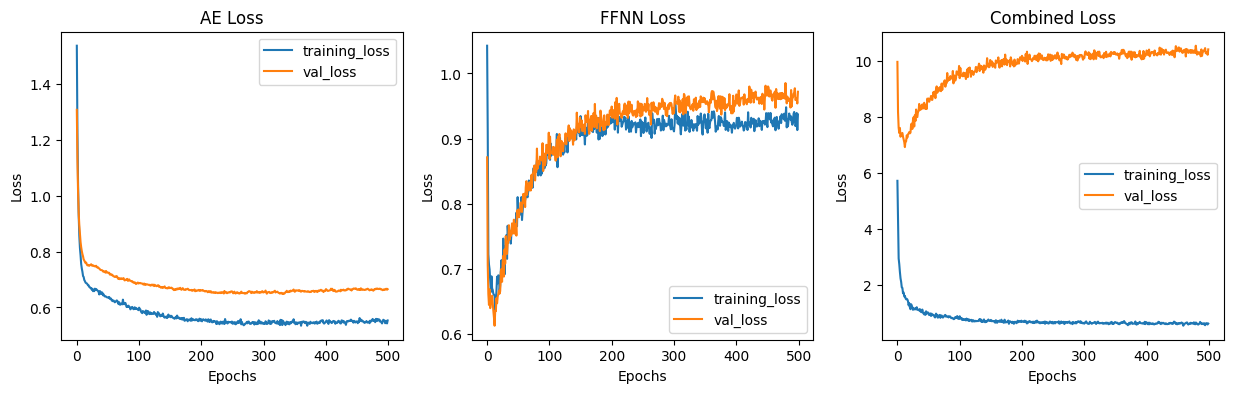

In [356]:
fig,ax = plt.subplots(1,3, figsize = (15,4))
title_best = ['AE Loss', 'FFNN Loss', 'Combined Loss']
keys_best = list(history_best.history.keys())
key_pairs_best = [(keys_best[i], keys_best[i+3]) for i in range(3)]

for i in range(3):
    ax[i].plot(history_best.history[key_pairs_best[i][0]], label='training_loss')
    ax[i].plot(history_best.history[key_pairs_best[i][1]], label='val_loss')

    ax[i].set_title(title_best[i])
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


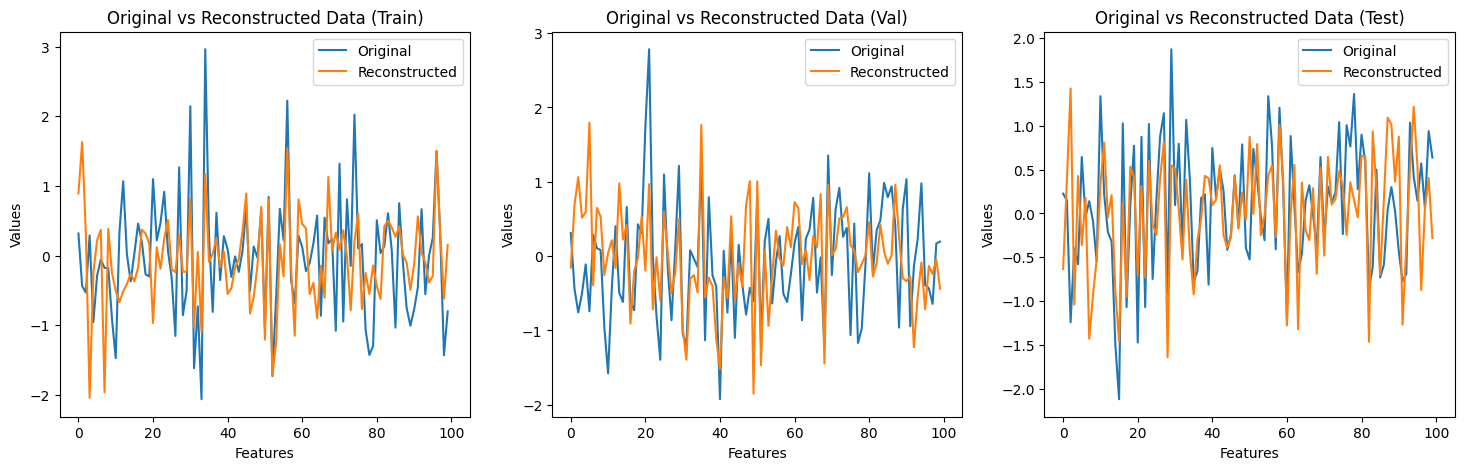

In [357]:
reconstructed_X_train_best = autoencoder_best.predict(X_train)
reconstructed_X_val_best = autoencoder_best.predict(X_val)
reconstructed_X_test_best = autoencoder_best.predict(X_test)

sample_idx_train_best = X_train[0]
sample_idx_val_best = X_val[0]
sample_idx_test_best = X_test[0]

fig, ax = plt.subplots(1,3, figsize = (18,5))

ax[0].plot(X_train[0], label = 'Original')
ax[1].plot(X_val[0], label = 'Original')
ax[2].plot(X_test[0], label = 'Original')

ax[0].plot(reconstructed_X_train_best[0], label = 'Reconstructed')
ax[1].plot(reconstructed_X_val_best[0], label = 'Reconstructed')
ax[2].plot(reconstructed_X_test_best[0], label = 'Reconstructed')

ax[0].set_xlabel('Features')
ax[0].set_ylabel('Values')

ax[1].set_xlabel('Features')
ax[1].set_ylabel('Values')

ax[2].set_xlabel('Features')
ax[2].set_ylabel('Values')

ax[0].set_title('Original vs Reconstructed Data (Train)')
ax[1].set_title('Original vs Reconstructed Data (Val)')
ax[2].set_title('Original vs Reconstructed Data (Test)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlim([-5, X.shape[1]+5])
ax[1].set_xlim([-5, X.shape[1]+5])
ax[2].set_xlim([-5, X.shape[1]+5])

plt.show()

In [358]:
pred_train_best = combined_model_best.predict(X_train)#, [X_train, y_train])
pred_val_best = combined_model_best.predict(X_val)#, [X_val, y_val])
pred_test_best = combined_model_best.predict(X_test)#, [X_test, y_test])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


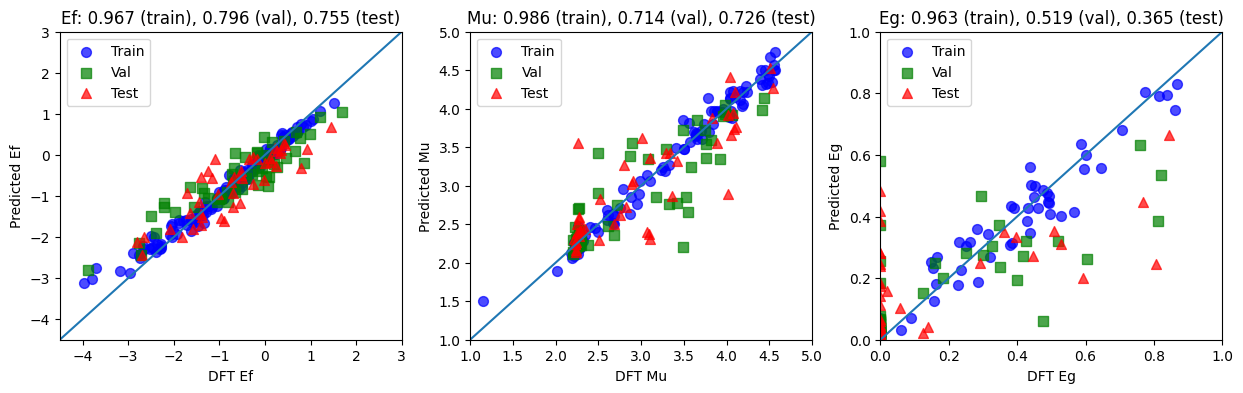

In [359]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (15,4))
ax1.scatter(y_train[mask_train==1][:, 0], pred_train_best[1][mask_train==1][:,0], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax1.scatter(y_val[mask_val==1][:, 0], pred_val_best[1][mask_val==1][:,0], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax1.scatter(y_test[mask_test==1][:, 0], pred_test_best[1][mask_test==1][:,0], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train[mask_train==1][:, 1], pred_train_best[1][mask_train==1][:,1], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax2.scatter(y_val[mask_val==1][:, 1], pred_val_best[1][mask_val==1][:,1], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax2.scatter(y_test[mask_test==1][:, 1], pred_test_best[1][mask_test==1][:,1], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax2.plot([0, 5], [0, 5])

ax3.scatter(y_train[mask_train==1][:, 2], pred_train_best[1][mask_train==1][:,2], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax3.scatter(y_val[mask_val==1][:, 2], pred_val_best[1][mask_val==1][:,2], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax3.scatter(y_test[mask_test==1][:, 2], pred_test_best[1][mask_test==1][:,2], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax3.plot([0, 1], [0, 1])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train[mask_train==1][:, 0], pred_train_best[1][mask_train==1][:,0]),metrics.r2_score(y_val[mask_val==1][:, 0], pred_val_best[1][mask_val==1][:,0]),metrics.r2_score(y_test[mask_test==1][:, 0], pred_test_best[1][mask_test==1][:,0])))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train[mask_train==1][:, 1], pred_train_best[1][mask_train==1][:,1]),metrics.r2_score(y_val[mask_val==1][:, 1], pred_val_best[1][mask_val==1][:,1]),metrics.r2_score(y_test[mask_test==1][:, 1], pred_test_best[1][mask_test==1][:,1])))
ax3.set_title('Eg: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train[mask_train==1][:, 2], pred_train_best[1][mask_train==1][:,2]),metrics.r2_score(y_val[mask_val==1][:, 2], pred_val_best[1][mask_val==1][:,2]),metrics.r2_score(y_test[mask_test==1][:, 2], pred_test_best[1][mask_test==1][:,2])))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax3.set_xlabel('DFT Eg')
ax3.set_ylabel('Predicted Eg')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

In [360]:
# Separate the labelled data from the predictions
mask_train_labelled = mask_train == 1
mask_val_labelled = mask_val == 1
mask_test_labelled = mask_test == 1

# Compute evaluation metrics for the labelled training data
r2_train_ef = metrics.r2_score(y_train[mask_train_labelled][:, 0], pred_train_best[1][mask_train_labelled][:, 0])
r2_train_mu = metrics.r2_score(y_train[mask_train_labelled][:, 1], pred_train_best[1][mask_train_labelled][:, 1])
r2_train_eg = metrics.r2_score(y_train[mask_train_labelled][:, 2], pred_train_best[1][mask_train_labelled][:, 2])

mae_train_ef = metrics.mean_absolute_error(y_train[mask_train_labelled][:, 0], pred_train_best[1][mask_train_labelled][:, 0])
mae_train_mu = metrics.mean_absolute_error(y_train[mask_train_labelled][:, 1], pred_train_best[1][mask_train_labelled][:, 1])
mae_train_eg = metrics.mean_absolute_error(y_train[mask_train_labelled][:, 2], pred_train_best[1][mask_train_labelled][:, 2])

# Compute evaluation metrics for the labelled validation data
r2_val_ef = metrics.r2_score(y_val[mask_val_labelled][:, 0], pred_val_best[1][mask_val_labelled][:, 0])
r2_val_mu = metrics.r2_score(y_val[mask_val_labelled][:, 1], pred_val_best[1][mask_val_labelled][:, 1])
r2_val_eg = metrics.r2_score(y_val[mask_val_labelled][:, 2], pred_val_best[1][mask_val_labelled][:, 2])

mae_val_ef = metrics.mean_absolute_error(y_val[mask_val_labelled][:, 0], pred_val_best[1][mask_val_labelled][:, 0])
mae_val_mu = metrics.mean_absolute_error(y_val[mask_val_labelled][:, 1], pred_val_best[1][mask_val_labelled][:, 1])
mae_val_eg = metrics.mean_absolute_error(y_val[mask_val_labelled][:, 2], pred_val_best[1][mask_val_labelled][:, 2])

# Compute evaluation metrics for the labelled test data
r2_test_ef = metrics.r2_score(y_test[mask_test_labelled][:, 0], pred_test_best[1][mask_test_labelled][:, 0])
r2_test_mu = metrics.r2_score(y_test[mask_test_labelled][:, 1], pred_test_best[1][mask_test_labelled][:, 1])
r2_test_eg = metrics.r2_score(y_test[mask_test_labelled][:, 2], pred_test_best[1][mask_test_labelled][:, 2])

mae_test_ef = metrics.mean_absolute_error(y_test[mask_test_labelled][:, 0], pred_test_best[1][mask_test_labelled][:, 0])
mae_test_mu = metrics.mean_absolute_error(y_test[mask_test_labelled][:, 1], pred_test_best[1][mask_test_labelled][:, 1])
mae_test_eg = metrics.mean_absolute_error(y_test[mask_test_labelled][:, 2], pred_test_best[1][mask_test_labelled][:, 2])

width = 10
print(f'{"Properties":>{width+1}} {"R2(Train)":>{width+1}} {"R2(Val)":>{width-1}} {"R2(Test)":>{width}} {"MAE(Train)":>{width+2}} {"MAE(Val)":>{width}} {"MAE(Test)":>{width}}')
print('='*80)
print(f'{"Ef":>{width}} {r2_train_ef:>{width}.3f} {r2_val_ef:>{width}.3f} {r2_test_ef:>{width}.3f} {mae_train_ef:>{width}.3f} {mae_val_ef:>{width}.3f} {mae_test_ef:>{width}.3f}')
print(f'{"Mu":>{width}} {r2_train_mu:>{width}.3f} {r2_val_mu:>{width}.3f} {r2_test_mu:>{width}.3f} {mae_train_mu:>{width}.3f} {mae_val_mu:>{width}.3f} {mae_test_mu:>{width}.3f}')
print(f'{"Eg":>{width}} {r2_train_eg:>{width}.3f} {r2_val_eg:>{width}.3f} {r2_test_eg:>{width}.3f} {mae_train_eg:>{width}.3f} {mae_val_eg:>{width}.3f} {mae_test_eg:>{width}.3f}')

 Properties   R2(Train)   R2(Val)   R2(Test)   MAE(Train)   MAE(Val)  MAE(Test)
        Ef      0.967      0.796      0.755      0.145      0.426      0.380
        Mu      0.986      0.714      0.726      0.073      0.267      0.275
        Eg      0.963      0.519      0.365      0.035      0.101      0.134


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


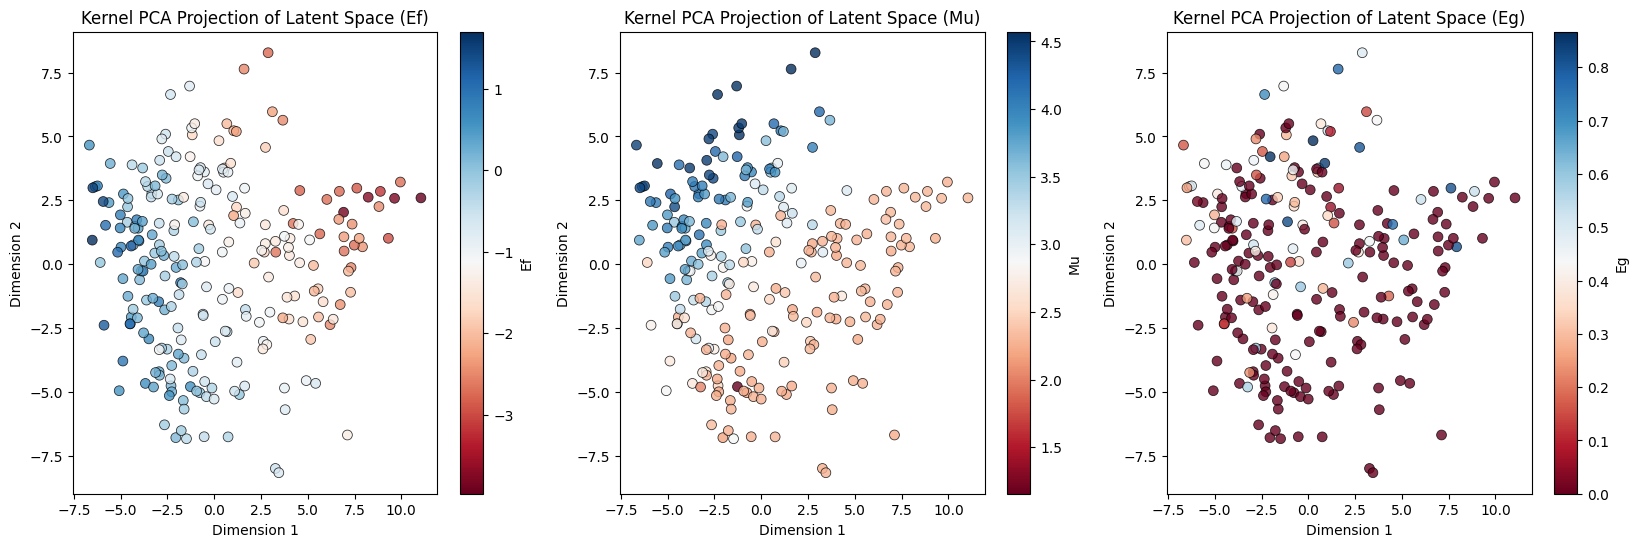

In [361]:
# Extract latent representations
encoder_model_best = Model(inputs = encoder_input_best, outputs = encoder_output_best)
latent_X_best = encoder_model_best.predict(X[:240,:])

# Apply Kernel PCA
kpca_best = KernelPCA(n_components=2, kernel='linear', gamma=None, fit_inverse_transform=True, alpha=1.0, n_jobs=-1)
kpca_embeddings_best = kpca_best.fit_transform(latent_X_best)

# Create a DataFrame for Seaborn
kpca_df_best = pd.DataFrame(data={'Dimension 1': kpca_embeddings_best[:, 0],
                             'Dimension 2': kpca_embeddings_best[:, 1],
                             'Ef': y['Ef_per_cell'],
                             'Mu': y['Mu_per_cell'],
                             'Eg': y['Eg']})

# Visualize the projected latent space using Seaborn
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
scatter_best_ef = sns.scatterplot(ax=ax[0], data=kpca_df_best, x='Dimension 1', y='Dimension 2', hue='Ef', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)
scatter_best_mu = sns.scatterplot(ax=ax[1], data=kpca_df_best, x='Dimension 1', y='Dimension 2', hue='Mu', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)
scatter_best_eg = sns.scatterplot(ax=ax[2], data=kpca_df_best, x='Dimension 1', y='Dimension 2', hue='Eg', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)

norm_best_ef = Normalize(vmin=kpca_df_best['Ef'].min(), vmax=kpca_df_best['Ef'].max())
norm_best_mu = Normalize(vmin=kpca_df_best['Mu'].min(), vmax=kpca_df_best['Mu'].max())
norm_best_eg = Normalize(vmin=kpca_df_best['Eg'].min(), vmax=kpca_df_best['Eg'].max())

sm_best_ef = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_best_ef)
sm_best_mu = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_best_mu)
sm_best_eg = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_best_eg)

sm_best_ef.set_array([])
sm_best_mu.set_array([])
sm_best_eg.set_array([])

cbar_best_ef = fig.colorbar(sm_best_ef, ax=ax[0])
cbar_best_mu = fig.colorbar(sm_best_mu, ax=ax[1])
cbar_best_eg = fig.colorbar(sm_best_eg, ax=ax[2])

cbar_best_ef.set_label('Ef')
cbar_best_mu.set_label('Mu')
cbar_best_eg.set_label('Eg')

ax[0].set_title('Kernel PCA Projection of Latent Space (Ef)')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')

ax[1].set_title('Kernel PCA Projection of Latent Space (Mu)')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')

ax[2].set_title('Kernel PCA Projection of Latent Space (Eg)')
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')

plt.show()